In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [ ]:
# Define the customer reviews
customer_reviews = [
"The battery lasts all day, and the performance is excellent.",
"The screen is too dim outdoors, but I love the colors indoors.",
"This phone is slow and keeps crashing when I open certain apps."
]
# Refine the prompt to include reviews
reviews_text = "\n".join([f"Review {i+1}: {review}" for i, review in enumerate(customer_reviews)])
prompt = f"""
Classify these reviews as Positive, Negative, or Mixed:
{reviews_text}
"""
# Invoke the model with the example prompt
response = output.invoke(prompt)
# Print the response
print("Granite Model Response:\n")
print(response)

Granite Model Response:

1. Positive: The battery lasts all day, and the performance is excellent.
2. Mixed: The screen is too dim outdoors, but I love the colors indoors.
3. Negative: This phone is slow and keeps crashing when I open certain apps.


In [ ]:
# Define refined prompt
refined_prompt = f"""
Classify these reviews as positive, negative, or mixed, and tag relevant categories (battery life, screen quality, or performance):
{reviews_text}
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt)
# Print the response
print("Granite Model Refined Response:\n")
print(response)

Granite Model Refined Response:

1. Review 1: Positive, Performance, Battery life
- This review is positive as it highlights the good aspects of the product. The reviewer mentions "excellent" performance and that the battery "lasts all day," categorizing it under performance and battery life.

2. Review 2: Mixed, Screen quality
- This review is mixed because it points out a flaw ("too dim outdoors") in the screen quality while also noting a positive ("love the colors indoors"). The review focuses on the screen quality category.

3. Review 3: Negative, Performance
- This review is negative as it criticizes the phone's performance, stating that it is "slow" and "keeps crashing." The review solely addresses the performance category.


In [ ]:
# Define the prompt to complete the task in 2 steps
multitask_prompt = f"""
Complete the task in 2 steps.
Step 1: Classify these reviews as positive, negative, or mixed.
Step 2: For each review, identify relevant categories: battery life, screen quality, or performance.
{reviews_text}
"""
response = output.invoke(multitask_prompt)
print("Granite Model Response:\n")
print(response)

Granite Model Response:

### Step 1: Classification

1. Review 1: Positive
2. Review 2: Mixed
3. Review 3: Negative

### Step 2: Identify Relevant Categories

1. **Review 1**: 
   - Category: Battery life (Positive)
   - Category: Performance (Positive)

2. **Review 2**: 
   - Category: Screen quality (Mixed, Dim outdoors but good colors indoors)

3. **Review 3**: 
   - Category: Performance (Negative, described as slow and prone to crashing)


In [ ]:
!pip install --upgrade google-api-python-client
!pip install transformers torch accelerate

In [ ]:
!pip install --upgrade google-api-python-client transformers torch accelerate tqdm pandas matplotlib seaborn
!pip install --quiet python-dotenv

In [ ]:
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from google.colab import userdata
import re
from urllib.parse import urlparse, parse_qs
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def setup_youtube_api():
    """
    Setup YouTube API menggunakan Google Colab Secrets
    """
    try:
        # Ambil API key dari Google Colab Secrets
        api_key = userdata.get('YOUTUBE_API')
        youtube = build('youtube', 'v3', developerKey=api_key)
        print("✅ YouTube API berhasil diinisialisasi menggunakan Colab Secrets")
        return youtube, api_key
    except Exception as e:
        print(f"❌ Error setup YouTube API: {e}")
        print("💡 Pastikan 'YOUTUBE_API' sudah ditambahkan di Colab Secrets")
        return None, None

In [ ]:
# Test API connection
youtube, api_key = setup_youtube_api()

✅ YouTube API berhasil diinisialisasi menggunakan Colab Secrets


In [ ]:
# ============================================================================
# 2. FUNGSI EKSTRAKSI VIDEO ID DAN VALIDASI
# ============================================================================

def extract_video_id(url):
    """
    Ekstrak video ID dari berbagai format URL YouTube
    """
    if not url:
        return None

    # Handle berbagai format URL
    if url.startswith(('youtu', 'www')):
        url = 'https://' + url

    query = urlparse(url)

    # YouTube regular URLs
    if 'youtube.com' in query.netlower():
        if query.path == '/watch':
            return parse_qs(query.query).get('v', [None])[0]
        elif query.path.startswith(('/embed/', '/v/')):
            return query.path.split('/')[41]

    # YouTube short URLs
    elif 'youtu.be' in query.netlower():
        return query.path[1:]

    # Regex fallback
    video_id_match = re.search(r"(?:v=|/)([a-zA-Z0-9_-]{11})", url)
    if video_id_match:
        return video_id_match.group(1)

    return None

def validate_video_id(youtube, video_id):
    """
    Validasi apakah video ID valid dan dapat diakses
    """
    try:
        response = youtube.videos().list(
            part='snippet,statistics',
            id=video_id
        ).execute()

        if response['items']:
            video_info = response['items']
            title = video_info['snippet']['title']
            comment_count = video_info['statistics'].get('commentCount', 0)
            print(f"✅ Video valid: '{title}' ({comment_count} komentar)")
            return True, title, int(comment_count)
        else:
            print(f"❌ Video ID tidak ditemukan: {video_id}")
            return False, None, 0
    except Exception as e:
        print(f"❌ Error validasi video: {e}")
        return False, None, 0


In [ ]:
# ============================================================================
# 3. FUNGSI EKSTRAKSI KOMENTAR DENGAN PAGINATION & BATCH PROCESSING
# ============================================================================

def get_all_comments_single_video(youtube, video_id, max_comments=2000):
    """
    Ekstraksi semua komentar dari satu video dengan pagination
    """
    comments = []
    next_page_token = None

    try:
        with tqdm(desc=f"Mengambil komentar {video_id}", unit="batch") as pbar:
            while len(comments) < max_comments:
                # Tentukan jumlah maksimum per batch
                batch_size = min(100, max_comments - len(comments))

                # Request ke YouTube API
                request = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=batch_size,
                    pageToken=next_page_token,
                    textFormat='plainText',
                    order='relevance'  # Ambil komentar paling relevan
                )

                response = request.execute()

                # Ekstrak data komentar
                for item in response['items']:
                    snippet = item['snippet']['topLevelComment']['snippet']

                    comment_data = {
                        'video_id': video_id,
                        'comment_id': item['snippet']['topLevelComment']['id'],
                        'comment': snippet['textDisplay'],
                        'author': snippet['authorDisplayName'],
                        'published_at': snippet['publishedAt'],
                        'like_count': snippet['likeCount'],
                        'updated_at': snippet.get('updatedAt', snippet['publishedAt'])
                    }
                    comments.append(comment_data)

                # Update progress bar
                pbar.set_postfix({
                    'total': len(comments),
                    'target': max_comments
                })
                pbar.update(1)

                # Check pagination
                next_page_token = response.get('nextPageToken')
                if not next_page_token:
                    print(f"✅ Mencapai akhir komentar (total: {len(comments)})")
                    break

                # Rate limiting - hindari quota exceeded
                time.sleep(0.1)

    except Exception as e:
        print(f"❌ Error mengambil komentar: {e}")
        if "quotaExceeded" in str(e):
            print("⚠️ Quota API harian habis. Coba lagi besok.")
        elif "commentsDisabled" in str(e):
            print("⚠️ Komentar dinonaktifkan untuk video ini.")

    return comments

def get_multiple_videos_comments(youtube, video_urls, target_comments=5000):
    """
    Ekstraksi komentar dari multiple video untuk mencapai target minimal
    """
    all_comments = []
    processed_videos = []

    print(f"🎯 Target: {target_comments} komentar dari {len(video_urls)} video")
    print("=" * 60)

    for i, url in enumerate(video_urls, 1):
        print(f"\n📹 Video {i}/{len(video_urls)}")

        # Ekstrak dan validasi video ID
        video_id = extract_video_id(url)
        if not video_id:
            print(f"❌ Tidak dapat mengekstrak video ID dari: {url}")
            continue

        # Validasi video
        is_valid, title, comment_count = validate_video_id(youtube, video_id)
        if not is_valid:
            continue

        # Hitung berapa komentar yang dibutuhkan
        remaining_target = target_comments - len(all_comments)
        if remaining_target <= 0:
            print(f"🎉 Target {target_comments} komentar sudah tercapai!")
            break

        # Tentukan limit per video
        comments_per_video = min(remaining_target, min(2000, comment_count))
        print(f"📊 Target dari video ini: {comments_per_video} komentar")

        # Ambil komentar
        video_comments = get_all_comments_single_video(
            youtube, video_id, comments_per_video
        )

        if video_comments:
            all_comments.extend(video_comments)
            processed_videos.append({
                'video_id': video_id,
                'title': title,
                'comments_extracted': len(video_comments),
                'url': url
            })

            print(f"✅ Berhasil: {len(video_comments)} komentar")
            print(f"📈 Total terkumpul: {len(all_comments)}/{target_comments}")

        # Jeda antar video
        time.sleep(1)

    return all_comments, processed_videos

In [ ]:
# ============================================================================
# 4. IMPLEMENTASI SENTIMENT ANALYSIS DENGAN IBM GRANITE VIA REPLICATE
# ============================================================================

# Install dependencies yang diperlukan
#!pip install --upgrade langchain-community replicate tqdm

# Import libraries
from langchain_community.llms import Replicate
import os
import time
from google.colab import userdata
from tqdm import tqdm
import pandas as pd

print("🔄 Setting up IBM Granite Model via Replicate...")

def setup_granite_model():
    """
    Setup IBM Granite model menggunakan Replicate API
    """
    try:
        # Get API token dari Google Colab Secrets
        api_token = userdata.get('REPLICATE_API_TOKEN')

        if not api_token:
            raise ValueError("REPLICATE_API_TOKEN tidak ditemukan di Colab Secrets")

        # Set environment variable
        os.environ["REPLICATE_API_TOKEN"] = api_token

        # Model setup dengan Replicate
        model_name = "ibm-granite/granite-3.3-8b-instruct"

        llm = Replicate(
            model=model_name,
            replicate_api_token=api_token,
            model_kwargs={
                "temperature": 0.1,
                "max_new_tokens": 50,
                "top_p": 0.9,
                "repetition_penalty": 1.0
            }
        )

        print("✅ IBM Granite model berhasil dimuat via Replicate")
        return llm

    except Exception as e:
        print(f"❌ Error loading Granite model: {e}")
        print("💡 Pastikan 'REPLICATE_API_TOKEN' sudah ditambahkan di Colab Secrets")
        print("💡 Dapatkan token di: https://replicate.com/account/api-tokens")
        return None

# Load model
granite_llm = setup_granite_model()

def classify_ihsg_sentiment_granite(comment, llm):
    """
    Klasifikasi sentimen menggunakan IBM Granite Model via Replicate
    """
    # Batasi panjang komentar untuk efisiensi
    comment_text = comment[:400] if len(comment) > 400 else comment

    prompt = f"""Analisis komentar berikut terkait prediksi Indeks Harga Saham Gabungan (IHSG) Indonesia mencapai level 8080 sebelum Hari Ulang Tahun Republik Indonesia (17 Agustus 2025):

Komentar: "{comment_text}"

Tugas: Klasifikasikan sentimen dan prediksi sebagai salah satu dari:
- PRO: Optimis/yakin IHSG bisa mencapai 8080 sebelum 17 Agustus
- CONTRA: Pesimis/meragukan IHSG mencapai 8080 sebelum 17 Agustus
- NEUTRAL: Tidak memiliki posisi jelas atau tidak relevan dengan topik IHSG

Jawab hanya dengan satu kata: PRO, CONTRA, atau NEUTRAL.

Klasifikasi:"""

    try:
        # Invoke model dengan prompt
        response = llm.invoke(prompt)

        # Clean response text
        result = response.strip().upper()

        # Parsing hasil berdasarkan keywords
        if any(keyword in result for keyword in ["PRO", "OPTIMIS", "YAKIN", "BULLISH", "POSITIF", "NAIK"]):
            return "PRO"
        elif any(keyword in result for keyword in ["CONTRA", "PESIMIS", "BEARISH", "NEGATIF", "SKEPTIS", "TURUN"]):
            return "CONTRA"
        elif "NEUTRAL" in result:
            return "NEUTRAL"
        else:
            # Jika tidak jelas, coba analisis lebih detail
            if any(keyword in result for keyword in ["BAGUS", "BAIK", "TINGGI", "MAMPU", "BISA"]):
                return "PRO"
            elif any(keyword in result for keyword in ["BURUK", "JELEK", "RENDAH", "TIDAK", "SULIT"]):
                return "CONTRA"
            else:
                return "NEUTRAL"

    except Exception as e:
        print(f"Error dalam klasifikasi untuk komentar: '{comment_text[:50]}...' - {e}")
        return "NEUTRAL"

def analyze_comments_batch_replicate(comments_df, llm, batch_size=25):
    """
    Analisis sentiment dalam batch untuk efisiensi dengan Replicate API
    """
    if comments_df.empty:
        print("❌ DataFrame kosong")
        return comments_df

    print(f"🔄 Memulai analisis sentimen untuk {len(comments_df)} komentar menggunakan IBM Granite...")
    print(f"📊 Batch size: {batch_size} | Estimasi waktu: {len(comments_df) * 3 / 60:.1f} menit")

    sentiments = []
    failed_count = 0

    # Process dalam batch dengan progress bar
    with tqdm(total=len(comments_df), desc="Analisis Sentimen") as pbar:
        for i in range(0, len(comments_df), batch_size):
            batch = comments_df.iloc[i:i+batch_size]

            batch_sentiments = []
            for idx, row in batch.iterrows():
                try:
                    sentiment = classify_ihsg_sentiment_granite(row['comment'], llm)
                    batch_sentiments.append(sentiment)

                    # Update progress
                    pbar.set_postfix({
                        'Current': sentiment,
                        'Failed': failed_count
                    })

                except Exception as e:
                    print(f"\n⚠️ Error pada baris {idx}: {e}")
                    batch_sentiments.append("NEUTRAL")
                    failed_count += 1

                # Update progress bar
                pbar.update(1)

                # Rate limiting untuk Replicate API
                time.sleep(1.5)  # Sesuaikan dengan limit Replicate

            sentiments.extend(batch_sentiments)

            # Jeda antar batch
            if i + batch_size < len(comments_df):
                print(f"\n🔄 Selesai batch {(i//batch_size)+1}, jeda 5 detik...")
                time.sleep(5)

    # Tambahkan hasil ke dataframe
    comments_df['sentiment'] = sentiments

    # Print summary
    sentiment_counts = comments_df['sentiment'].value_counts()
    total = len(comments_df)

    print(f"\n📊 HASIL ANALISIS SENTIMEN:")
    print(f"Total dianalisis: {total}")
    print(f"PRO: {sentiment_counts.get('PRO', 0)} ({sentiment_counts.get('PRO', 0)/total*100:.1f}%)")
    print(f"CONTRA: {sentiment_counts.get('CONTRA', 0)} ({sentiment_counts.get('CONTRA', 0)/total*100:.1f}%)")
    print(f"NEUTRAL: {sentiment_counts.get('NEUTRAL', 0)} ({sentiment_counts.get('NEUTRAL', 0)/total*100:.1f}%)")
    print(f"Failed: {failed_count}")

    return comments_df

# Test function untuk memverifikasi setup
def test_granite_model():
    """
    Test function untuk memverifikasi IBM Granite model bekerja
    """
    if not granite_llm:
        print("❌ Model tidak tersedia")
        return False

    print("🧪 Testing IBM Granite model...")

    test_comments = [
        "IHSG pasti bisa tembus 8080 sebelum 17 Agustus! Bullish sekali!",
        "Kayaknya susah deh IHSG sampai 8080, masih banyak tekanan jual",
        "Ini video tentang resep masakan, tidak ada hubungannya dengan saham"
    ]

    for comment in test_comments:
        try:
            sentiment = classify_ihsg_sentiment_granite(comment, granite_llm)
            print(f"📝 '{comment[:50]}...' → {sentiment}")
        except Exception as e:
            print(f"❌ Error: {e}")
            return False

        time.sleep(2)  # Rate limiting

    print("✅ Test berhasil!")
    return True

# Setup tambahan untuk mengatasi error import
def fix_import_errors():
    """
    Fungsi untuk mengatasi common import errors
    """
    try:
        # Update packages jika diperlukan
        print("🔧 Memeriksa dan update packages...")

        # Coba import basic libraries
        import torch
        print(f"✅ PyTorch version: {torch.__version__}")

        # Skip transformers pipeline yang bermasalah
        print("ℹ️ Menggunakan Replicate API, melewati transformers pipeline")

        return True

    except ImportError as e:
        print(f"⚠️ Import warning: {e}")
        print("ℹ️ Melanjutkan dengan Replicate API...")
        return True

# Jalankan fix dan test
if __name__ == "__main__":
    print("🚀 SETUP IBM GRANITE VIA REPLICATE")
    print("=" * 50)

    # Fix import issues
    fix_import_errors()

    # Test model jika tersedia
    if granite_llm:
        test_granite_model()
    else:
        print("❌ Setup model gagal. Periksa REPLICATE_API_TOKEN di Colab Secrets")
        print("📝 Steps to fix:")
        print("   1. Buka sidebar kiri di Colab → klik 'Secrets'")
        print("   2. Add secret: Name='REPLICATE_API_TOKEN', Value='your_token_here'")
        print("   3. Get token dari: https://replicate.com/account/api-tokens")

🔄 Setting up IBM Granite Model via Replicate...
✅ IBM Granite model berhasil dimuat via Replicate
🚀 SETUP IBM GRANITE VIA REPLICATE
🔧 Memeriksa dan update packages...
✅ PyTorch version: 2.8.0+cu128
ℹ️ Menggunakan Replicate API, melewati transformers pipeline
🧪 Testing IBM Granite model...
📝 'IHSG pasti bisa tembus 8080 sebelum 17 Agustus! Bu...' → PRO
📝 'Kayaknya susah deh IHSG sampai 8080, masih banyak ...' → CONTRA
📝 'Ini video tentang resep masakan, tidak ada hubunga...' → NEUTRAL
✅ Test berhasil!


In [ ]:
# ============================================================================
# 5. VISUALISASI & REPORTING
# ============================================================================

def generate_comprehensive_report(analyzed_df, processed_videos):
    """
    Generate laporan komprehensif hasil analisis
    """
    print("\n" + "="*60)
    print("📊 LAPORAN ANALISIS SENTIMEN IHSG 8080 SEBELUM HUT RI")
    print("="*60)

    # Basic statistics
    total_comments = len(analyzed_df)
    total_videos = len(processed_videos)

    print(f"\n📈 STATISTIK DASAR:")
    print(f"Total komentar dianalisis: {total_comments:,}")
    print(f"Total video diproses: {total_videos}")
    print(f"Periode analisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Sentiment distribution
    sentiment_counts = analyzed_df['sentiment'].value_counts()
    sentiment_pct = analyzed_df['sentiment'].value_counts(normalize=True) * 100

    print(f"\n🎯 DISTRIBUSI SENTIMEN:")
    for sentiment in ['PRO', 'CONTRA', 'NEUTRAL']:
        count = sentiment_counts.get(sentiment, 0)
        pct = sentiment_pct.get(sentiment, 0)
        print(f"{sentiment:8}: {count:5} komentar ({pct:5.1f}%)")

    # Key insights
    pro_pct = sentiment_pct.get('PRO', 0)
    contra_pct = sentiment_pct.get('CONTRA', 0)

    print(f"\n💡 KEY INSIGHTS:")
    if pro_pct > contra_pct:
        margin = pro_pct - contra_pct
        print(f"• Sentimen OPTIMIS mendominasi dengan selisih {margin:.1f}%")
        print(f"• {pro_pct:.1f}% publik optimis IHSG mencapai 8080 sebelum HUT RI")
    elif contra_pct > pro_pct:
        margin = contra_pct - pro_pct
        print(f"• Sentimen PESIMIS mendominasi dengan selisih {margin:.1f}%")
        print(f"• {contra_pct:.1f}% publik meragukan IHSG mencapai 8080 sebelum HUT RI")
    else:
        print(f"• Sentimen berimbang antara optimis dan pesimis")

    # Video breakdown
    print(f"\n📹 BREAKDOWN PER VIDEO:")
    for i, video in enumerate(processed_videos, 1):
        print(f"{i}. {video['title'][:50]}... ({video['comments_extracted']} komentar)")

    return sentiment_counts, sentiment_pct

def create_visualizations(analyzed_df):
    """
    Buat visualisasi hasil analisis
    """
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Pie chart distribusi sentimen
    sentiment_counts = analyzed_df['sentiment'].value_counts()
    colors = ['#2ecc71', '#e74c3c', '#95a5a6']  # Green, Red, Gray

    axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index,
                  autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0,0].set_title('Distribusi Sentimen IHSG ke 8080\nSebelum HUT RI 2025',
                        fontsize=14, fontweight='bold')

    # 2. Bar chart
    bars = axes[0,1].bar(sentiment_counts.index, sentiment_counts.values,
                         color=colors, alpha=0.8)
    axes[0,1].set_title('Jumlah Komentar per Kategori Sentimen',
                        fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Jumlah Komentar')

    # Tambah nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')

    # 3. Sentiment over time (jika data cukup)
    try:
        analyzed_df['date'] = pd.to_datetime(analyzed_df['published_at']).dt.date
        daily_sentiment = analyzed_df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

        if len(daily_sentiment) > 1:
            daily_sentiment.plot(kind='area', ax=axes[1,0], alpha=0.7, color=colors)
            axes[1,0].set_title('Trend Sentimen Harian', fontsize=14, fontweight='bold')
            axes[1,0].set_xlabel('Tanggal')
            axes[1,0].set_ylabel('Jumlah Komentar')
            axes[1,0].legend()
        else:
            axes[1,0].text(0.5, 0.5, 'Data tidak cukup\nuntuk trend harian',
                           ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Trend Sentimen Harian (Tidak tersedia)')
    except:
        axes[1,0].text(0.5, 0.5, 'Error membuat\ntrend harian',
                       ha='center', va='center', transform=axes[1,0].transAxes)

    # 4. Like count vs sentiment
    try:
        sentiment_likes = analyzed_df.groupby('sentiment')['like_count'].mean()
        bars = axes[1,1].bar(sentiment_likes.index, sentiment_likes.values,
                             color=colors, alpha=0.8)
        axes[1,1].set_title('Rata-rata Like per Kategori Sentimen',
                            fontsize=14, fontweight='bold')
        axes[1,1].set_ylabel('Rata-rata Like Count')

        # Tambah nilai di atas bar
        for bar in bars:
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom')
    except:
        axes[1,1].text(0.5, 0.5, 'Error membuat\nanalisis like',
                       ha='center', va='center', transform=axes[1,1].transAxes)

    plt.tight_layout()
    plt.show()


🚀 ANALISIS SENTIMEN IHSG 8080 - IBM GRANITE VIA REPLICATE

📥 STEP 1: EKSTRAKSI KOMENTAR
🎯 Target: 5000 komentar dari 4 video

📹 Video 1/4
✅ Video valid: 'IHSG 8000 MANUVER MAUT PRABOWO!! Menang Perang Dagang AS, Investor SAHAM SENANG?' (4319 komentar)
📊 Target dari video ini: 2000 komentar


Mengambil komentar wYtvewS_Dlo: 10batch [00:03,  2.51batch/s, total=921, target=2000]


✅ Mencapai akhir komentar (total: 921)
✅ Berhasil: 921 komentar
📈 Total terkumpul: 921/5000

📹 Video 2/4
✅ Video valid: 'IHSG MULAI NAIK !!! SIAPIN CASH BUAT MENUNGGU MARKET CRASH ??' (85 komentar)
📊 Target dari video ini: 85 komentar


Mengambil komentar G_gZ9nvfJBg: 1batch [00:00,  4.66batch/s, total=34, target=85]


✅ Mencapai akhir komentar (total: 34)
✅ Berhasil: 34 komentar
📈 Total terkumpul: 955/5000

📹 Video 3/4
✅ Video valid: '#UBBM 08/22: Goreng IHSG ke 8.000, Strategi Supir CDIA, CUAN, BBRI & Bahaya Market Bubble' (152 komentar)
📊 Target dari video ini: 152 komentar


Mengambil komentar QC6PPJQV94U: 2batch [00:00,  4.60batch/s, total=110, target=152]


✅ Mencapai akhir komentar (total: 110)
✅ Berhasil: 110 komentar
📈 Total terkumpul: 1065/5000

📹 Video 4/4
✅ Video valid: 'IHSG Kian Mendekati 8.000: Momentum Emas Pasar Modal Indonesia | THE EDITORIAL' (28 komentar)
📊 Target dari video ini: 28 komentar


Mengambil komentar RXPiHqwjVSg: 1batch [00:00,  6.10batch/s, total=17, target=28]


✅ Mencapai akhir komentar (total: 17)
✅ Berhasil: 17 komentar
📈 Total terkumpul: 1082/5000
✅ Berhasil mengumpulkan 1082 komentar

🔧 STEP 2: PREPROCESSING
📊 After filtering: 1082 → 500 komentar

🤖 STEP 3: ANALISIS SENTIMEN (IBM GRANITE VIA REPLICATE)
🔄 Memulai analisis sentimen untuk 500 komentar menggunakan IBM Granite...
📊 Batch size: 20 | Estimasi waktu: 25.0 menit


Analisis Sentimen:   4%|▍         | 20/500 [00:49<21:16,  2.66s/it, Current=PRO, Failed=0]


🔄 Selesai batch 1, jeda 5 detik...


Analisis Sentimen:   8%|▊         | 40/500 [01:44<19:03,  2.49s/it, Current=PRO, Failed=0]


🔄 Selesai batch 2, jeda 5 detik...


Analisis Sentimen:  12%|█▏        | 60/500 [02:41<17:59,  2.45s/it, Current=PRO, Failed=0]


🔄 Selesai batch 3, jeda 5 detik...


Analisis Sentimen:  16%|█▌        | 80/500 [03:34<16:02,  2.29s/it, Current=PRO, Failed=0]


🔄 Selesai batch 4, jeda 5 detik...


Analisis Sentimen:  20%|██        | 100/500 [04:29<15:37,  2.34s/it, Current=PRO, Failed=0]


🔄 Selesai batch 5, jeda 5 detik...


Analisis Sentimen:  24%|██▍       | 120/500 [05:26<16:14,  2.56s/it, Current=PRO, Failed=0]


🔄 Selesai batch 6, jeda 5 detik...


Analisis Sentimen:  28%|██▊       | 140/500 [06:22<13:46,  2.30s/it, Current=PRO, Failed=0]


🔄 Selesai batch 7, jeda 5 detik...


Analisis Sentimen:  32%|███▏      | 160/500 [07:16<14:46,  2.61s/it, Current=PRO, Failed=0]


🔄 Selesai batch 8, jeda 5 detik...


Analisis Sentimen:  36%|███▌      | 180/500 [08:11<13:46,  2.58s/it, Current=PRO, Failed=0]


🔄 Selesai batch 9, jeda 5 detik...


Analisis Sentimen:  40%|████      | 200/500 [09:04<11:45,  2.35s/it, Current=PRO, Failed=0]


🔄 Selesai batch 10, jeda 5 detik...


Analisis Sentimen:  44%|████▍     | 220/500 [09:56<11:22,  2.44s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 11, jeda 5 detik...


Analisis Sentimen:  48%|████▊     | 240/500 [10:51<11:16,  2.60s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 12, jeda 5 detik...


Analisis Sentimen:  52%|█████▏    | 260/500 [11:44<09:51,  2.47s/it, Current=PRO, Failed=0]


🔄 Selesai batch 13, jeda 5 detik...


Analisis Sentimen:  56%|█████▌    | 280/500 [12:43<09:31,  2.60s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 14, jeda 5 detik...


Analisis Sentimen:  60%|██████    | 300/500 [13:34<07:48,  2.34s/it, Current=NEUTRAL, Failed=0]


🔄 Selesai batch 15, jeda 5 detik...


Analisis Sentimen:  64%|██████▍   | 320/500 [14:28<07:21,  2.45s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 16, jeda 5 detik...


Analisis Sentimen:  68%|██████▊   | 340/500 [15:21<06:22,  2.39s/it, Current=PRO, Failed=0]


🔄 Selesai batch 17, jeda 5 detik...


Analisis Sentimen:  72%|███████▏  | 360/500 [16:17<05:43,  2.46s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 18, jeda 5 detik...


Analisis Sentimen:  76%|███████▌  | 380/500 [17:12<04:59,  2.49s/it, Current=PRO, Failed=0]


🔄 Selesai batch 19, jeda 5 detik...


Analisis Sentimen:  80%|████████  | 400/500 [18:08<04:13,  2.53s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 20, jeda 5 detik...


Analisis Sentimen:  84%|████████▍ | 420/500 [19:06<03:45,  2.82s/it, Current=PRO, Failed=0]


🔄 Selesai batch 21, jeda 5 detik...


Analisis Sentimen:  88%|████████▊ | 440/500 [19:59<02:34,  2.58s/it, Current=PRO, Failed=0]


🔄 Selesai batch 22, jeda 5 detik...


Analisis Sentimen:  92%|█████████▏| 460/500 [20:55<01:45,  2.63s/it, Current=PRO, Failed=0]


🔄 Selesai batch 23, jeda 5 detik...


Analisis Sentimen:  96%|█████████▌| 480/500 [21:50<00:46,  2.33s/it, Current=CONTRA, Failed=0]


🔄 Selesai batch 24, jeda 5 detik...


Analisis Sentimen: 100%|██████████| 500/500 [22:48<00:00,  2.74s/it, Current=CONTRA, Failed=0]



📊 HASIL ANALISIS SENTIMEN:
Total dianalisis: 500
PRO: 319 (63.8%)
CONTRA: 105 (21.0%)
NEUTRAL: 76 (15.2%)
Failed: 0

📋 STEP 4: GENERATE LAPORAN

📊 LAPORAN ANALISIS SENTIMEN IHSG 8080 SEBELUM HUT RI

📈 STATISTIK DASAR:
Total komentar dianalisis: 500
Total video diproses: 4
Periode analisis: 2025-08-15 14:59:02

🎯 DISTRIBUSI SENTIMEN:
PRO     :   319 komentar ( 63.8%)
CONTRA  :   105 komentar ( 21.0%)
NEUTRAL :    76 komentar ( 15.2%)

💡 KEY INSIGHTS:
• Sentimen OPTIMIS mendominasi dengan selisih 42.8%
• 63.8% publik optimis IHSG mencapai 8080 sebelum HUT RI

📹 BREAKDOWN PER VIDEO:
1. IHSG 8000 MANUVER MAUT PRABOWO!! Menang Perang Dag... (921 komentar)
2. IHSG MULAI NAIK !!! SIAPIN CASH BUAT MENUNGGU MARK... (34 komentar)
3. #UBBM 08/22: Goreng IHSG ke 8.000, Strategi Supir ... (110 komentar)
4. IHSG Kian Mendekati 8.000: Momentum Emas Pasar Mod... (17 komentar)

📊 STEP 5: VISUALISASI


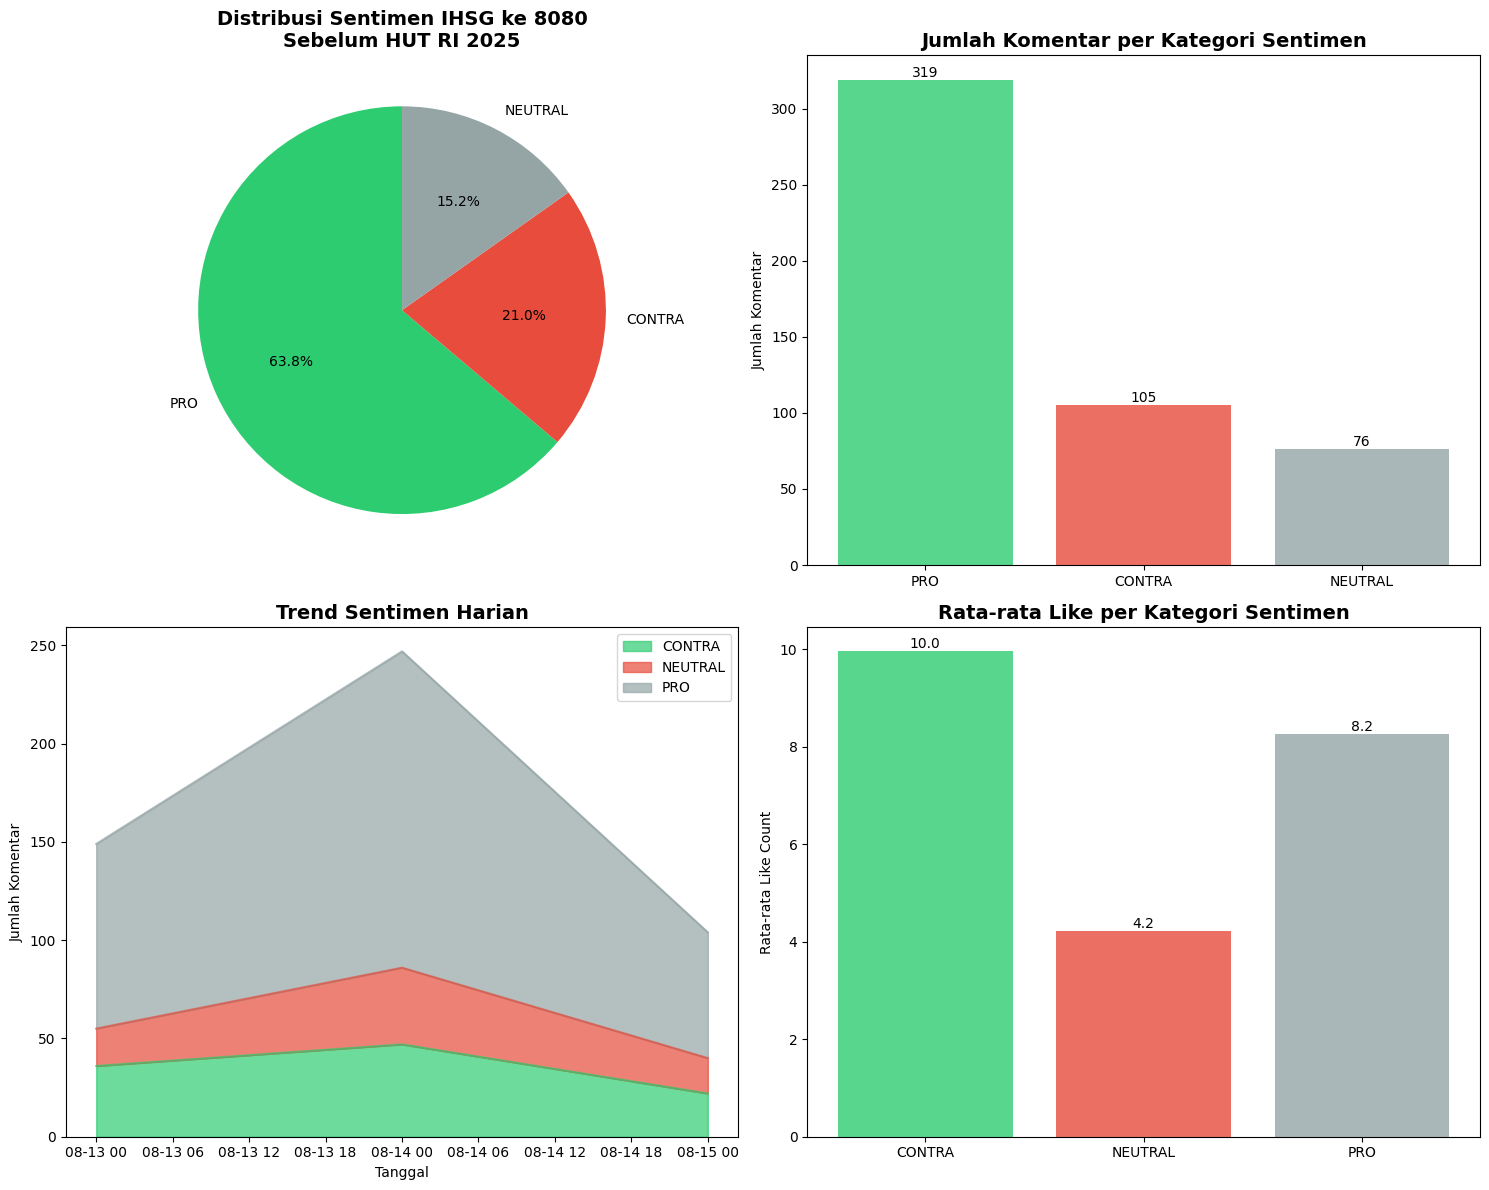


💾 STEP 6: MENYIMPAN HASIL
✅ Data disimpan: 'ihsg_8080_sentiment_replicate.csv'


In [ ]:
def main_analysis_workflow_fixed():
    """
    Workflow utama dengan IBM Granite via Replicate
    """
    print("🚀 ANALISIS SENTIMEN IHSG 8080 - IBM GRANITE VIA REPLICATE")
    print("=" * 60)

    # Pastikan model tersedia
    if not granite_llm:
        print("❌ IBM Granite model tidak tersedia. Setup Replicate API Token.")
        return None

    # URL video (GANTI DENGAN URL YANG SESUAI)
    video_urls = [
        "https://youtu.be/wYtvewS_Dlo?si=mUor-iEo4jQyS0W8",
        "https://youtu.be/G_gZ9nvfJBg?si=BNOldOPlVI_5wf3K",
        "https://youtu.be/QC6PPJQV94U?si=dxGAuCRqQA_sYwH5",
        "https://www.youtube.com/watch?v=RXPiHqwjVSg"
    ]

    TARGET_COMMENTS = 5000

    # Step 1: Ekstraksi komentar (menggunakan kode sebelumnya)
    print("\n📥 STEP 1: EKSTRAKSI KOMENTAR")
    comments_list, processed_videos = get_multiple_videos_comments(
        youtube, video_urls, TARGET_COMMENTS
    )

    if not comments_list:
        print("❌ Tidak ada komentar yang berhasil diekstrak")
        return None

    comments_df = pd.DataFrame(comments_list)
    print(f"✅ Berhasil mengumpulkan {len(comments_df)} komentar")

    # Step 2: Preprocessing
    print("\n🔧 STEP 2: PREPROCESSING")
    initial_count = len(comments_df)
    comments_df = comments_df[comments_df['comment'].str.len() >= 10]
    comments_df = comments_df.drop_duplicates(subset=['comment'])
    comments_df = comments_df.head(min(500, len(comments_df)))  # Limit untuk demo
    comments_df.reset_index(drop=True, inplace=True)

    print(f"📊 After filtering: {initial_count} → {len(comments_df)} komentar")

    # Step 3: Sentiment Analysis dengan Replicate
    print("\n🤖 STEP 3: ANALISIS SENTIMEN (IBM GRANITE VIA REPLICATE)")
    analyzed_df = analyze_comments_batch_replicate(
        comments_df, granite_llm, batch_size=20
    )

    # Step 4: Generate Report & Visualisasi (gunakan fungsi sebelumnya)
    print("\n📋 STEP 4: GENERATE LAPORAN")
    sentiment_counts, sentiment_pct = generate_comprehensive_report(
        analyzed_df, processed_videos
    )

    print("\n📊 STEP 5: VISUALISASI")
    create_visualizations(analyzed_df)

    # Save results
    print("\n💾 STEP 6: MENYIMPAN HASIL")
    analyzed_df.to_csv('ihsg_8080_sentiment_replicate.csv', index=False)
    print("✅ Data disimpan: 'ihsg_8080_sentiment_replicate.csv'")

    return analyzed_df

# Jalankan workflow
result_df = main_analysis_workflow_fixed()

In [ ]:
# ============================================================================
# 7. EXECUTE MAIN WORKFLOW
# ============================================================================

if __name__ == "__main__":
    # Pastikan semua setup berhasil
    if youtube and generator:
        print("🔄 Semua komponen siap. Memulai analisis...")

        # GANTI video_urls dengan URL yang relevan
        print("\n⚠️  IMPORTANT: Ganti video_urls dengan URL YouTube yang relevan!")
        print("📝 Cari video dengan topik: IHSG, saham Indonesia, prediksi pasar modal, dll.")

        # Uncomment line berikut setelah mengganti URL
        # result_df, summary = main_analysis_workflow()

    else:
        print("❌ Setup tidak lengkap. Periksa API key dan model loading.")

🔄 Semua komponen siap. Memulai analisis...

⚠️  IMPORTANT: Ganti video_urls dengan URL YouTube yang relevan!
📝 Cari video dengan topik: IHSG, saham Indonesia, prediksi pasar modal, dll.


In [ ]:
# ============================================================================
# 7. EXECUTE MAIN WORKFLOW - FIXED VERSION
# ============================================================================

if __name__ == "__main__":
    print("🚀 MEMULAI WORKFLOW ANALISIS SENTIMEN IHSG 8080")
    print("=" * 60)

    # Cek semua komponen yang diperlukan
    components_ready = True

    # 1. Cek YouTube API
    if 'youtube' in locals() and youtube is not None:
        print("✅ YouTube API: Ready")
    else:
        print("❌ YouTube API: Not ready")
        components_ready = False

    # 2. Cek IBM Granite Model (Replicate)
    if 'granite_llm' in locals() and granite_llm is not None:
        print("✅ IBM Granite Model (Replicate): Ready")
    else:
        print("❌ IBM Granite Model (Replicate): Not ready")
        components_ready = False

    # 3. Status check
    if components_ready:
        print("\n🔄 Semua komponen siap. Siap memulai analisis...")
        print("\n" + "="*50)
        print("📋 CHECKLIST SEBELUM MENJALANKAN:")
        print("✓ YouTube API setup dengan Colab Secrets")
        print("✓ Replicate API Token setup dengan Colab Secrets")
        print("✓ IBM Granite model loaded")
        print("⚠️  PENTING: Pastikan sudah mengganti video_urls dengan URL yang relevan!")
        print("📝 Topik yang disarankan: IHSG, saham Indonesia, prediksi pasar modal")
        print("="*50)

        # Uncomment dan modifikasi bagian ini setelah setup URL
        print("\n🎯 Untuk menjalankan analisis, uncomment dan jalankan:")
        print("result_df = main_analysis_workflow_fixed()")

    else:
        print("\n❌ Setup tidak lengkap. Periksa komponen yang gagal:")

        if 'youtube' not in locals() or youtube is None:
            print("   🔧 YouTube API: Periksa YOUTUBE_API di Colab Secrets")
            print("      - Buka sidebar → Secrets → Add 'YOUTUBE_API'")

        if 'granite_llm' not in locals() or granite_llm is None:
            print("   🔧 Replicate Model: Periksa REPLICATE_API_TOKEN di Colab Secrets")
            print("      - Buka sidebar → Secrets → Add 'REPLICATE_API_TOKEN'")
            print("      - Get token: https://replicate.com/account/api-tokens")

# ============================================================================
# 8. COMPLETE WORKFLOW FUNCTION - READY TO USE
# ============================================================================

def main_analysis_workflow_fixed():
    """
    Complete workflow untuk analisis sentimen IHSG 8080 sebelum HUT RI
    """
    print("🚀 MEMULAI ANALISIS SENTIMEN IHSG 8080 - IBM GRANITE VIA REPLICATE")
    print("=" * 70)

    # Validasi komponen
    if not youtube:
        print("❌ YouTube API tidak tersedia")
        return None

    if not granite_llm:
        print("❌ IBM Granite model tidak tersedia")
        return None

    # =======================================================================
    # STEP 0: SETUP VIDEO URLs - GANTI DENGAN URL YANG RELEVAN
    # =======================================================================

    print("\n📹 STEP 0: SETUP VIDEO URLs")

    # CONTOH URLs - GANTI DENGAN URL YOUTUBE YANG SESUAI
    video_urls = [
        # TEMPLATE - Ganti dengan URL nyata

        "https://youtu.be/wYtvewS_Dlo?si=mUor-iEo4jQyS0W8",
        "https://youtu.be/G_gZ9nvfJBg?si=BNOldOPlVI_5wf3K",
        "https://youtu.be/QC6PPJQV94U?si=dxGAuCRqQA_sYwH5",
        "https://www.youtube.com/watch?v=RXPiHqwjVSg"


        # Tambahkan lebih banyak URL sesuai kebutuhan
        # Cari video dengan topik: "IHSG", "saham Indonesia", "bursa efek",
        # "investasi saham", "prediksi pasar modal", dll.
    ]

    # Cek apakah URL masih template
    if any("EXAMPLE_VIDEO_ID" in url for url in video_urls):
        print("⚠️  WARNING: Masih menggunakan template URL!")
        print("📝 Silakan ganti video_urls dengan URL YouTube yang relevan")
        print("🔍 Cari video dengan topik:")
        print("   - IHSG naik/turun")
        print("   - Saham Indonesia")
        print("   - Prediksi pasar modal")
        print("   - Analisis bursa efek")

        # Return early jika masih template
        user_input = input("\nLanjutkan dengan template URL? (y/n): ")
        if user_input.lower() != 'y':
            print("❌ Workflow dihentikan. Ganti URL terlebih dahulu.")
            return None

    TARGET_COMMENTS = 5000
    print(f"🎯 Target: {TARGET_COMMENTS} komentar")

    # =======================================================================
    # STEP 1: EKSTRAKSI KOMENTAR YOUTUBE
    # =======================================================================

    print(f"\n📥 STEP 1: EKSTRAKSI KOMENTAR dari {len(video_urls)} video")

    try:
        comments_list, processed_videos = get_multiple_videos_comments(
            youtube, video_urls, TARGET_COMMENTS
        )
    except Exception as e:
        print(f"❌ Error ekstraksi komentar: {e}")
        return None

    if not comments_list:
        print("❌ Tidak ada komentar yang berhasil diekstrak")
        print("💡 Tips:")
        print("   - Periksa video ID dalam URL")
        print("   - Pastikan video memiliki komentar yang enabled")
        print("   - Coba video dengan lebih banyak komentar")
        return None

    comments_df = pd.DataFrame(comments_list)
    print(f"✅ Berhasil mengumpulkan {len(comments_df)} komentar")

    # =======================================================================
    # STEP 2: DATA PREPROCESSING
    # =======================================================================

    print(f"\n🔧 STEP 2: PREPROCESSING DATA")

    initial_count = len(comments_df)

    # Filter komentar
    print("   - Filtering komentar minimal 10 karakter...")
    comments_df = comments_df[comments_df['comment'].str.len() >= 10]

    print("   - Menghapus duplikasi...")
    comments_df = comments_df.drop_duplicates(subset=['comment'])

    # Limit untuk demo/testing - sesuaikan jika diperlukan
    if len(comments_df) > 200:  # Limit untuk demo
        print(f"   - Limiting ke 200 komentar untuk demo...")
        comments_df = comments_df.head(200)

    comments_df.reset_index(drop=True, inplace=True)

    print(f"📊 Data processed: {initial_count} → {len(comments_df)} komentar")

    # =======================================================================
    # STEP 3: SENTIMENT ANALYSIS DENGAN IBM GRANITE
    # =======================================================================

    print(f"\n🤖 STEP 3: ANALISIS SENTIMEN (IBM GRANITE VIA REPLICATE)")
    print(f"📊 Memproses {len(comments_df)} komentar...")

    try:
        analyzed_df = analyze_comments_batch_replicate(
            comments_df, granite_llm, batch_size=15
        )
    except Exception as e:
        print(f"❌ Error analisis sentimen: {e}")
        return None

    # =======================================================================
    # STEP 4: GENERATE COMPREHENSIVE REPORT
    # =======================================================================

    print(f"\n📋 STEP 4: GENERATE LAPORAN KOMPREHENSIF")

    try:
        sentiment_counts, sentiment_pct = generate_comprehensive_report(
            analyzed_df, processed_videos
        )
    except Exception as e:
        print(f"❌ Error generate report: {e}")
        sentiment_counts = analyzed_df['sentiment'].value_counts()
        sentiment_pct = analyzed_df['sentiment'].value_counts(normalize=True) * 100

    # =======================================================================
    # STEP 5: VISUALISASI HASIL
    # =======================================================================

    print(f"\n📊 STEP 5: VISUALISASI HASIL")

    try:
        create_visualizations(analyzed_df)
    except Exception as e:
        print(f"⚠️  Error visualisasi: {e}")
        print("📊 Menampilkan statistik sederhana:")
        print(sentiment_counts)

    # =======================================================================
    # STEP 6: SAVE RESULTS
    # =======================================================================

    print(f"\n💾 STEP 6: MENYIMPAN HASIL")

    try:
        # Save raw data
        filename_csv = f'ihsg_8080_sentiment_analysis_{pd.Timestamp.now().strftime("%Y%m%d_%H%M")}.csv'
        analyzed_df.to_csv(filename_csv, index=False)
        print(f"✅ Raw data disimpan: '{filename_csv}'")

        # Save summary
        summary_report = {
            'analysis_timestamp': pd.Timestamp.now().isoformat(),
            'total_comments': len(analyzed_df),
            'total_videos_processed': len(processed_videos),
            'target_comments': TARGET_COMMENTS,
            'sentiment_distribution': {
                'PRO': int(sentiment_counts.get('PRO', 0)),
                'CONTRA': int(sentiment_counts.get('CONTRA', 0)),
                'NEUTRAL': int(sentiment_counts.get('NEUTRAL', 0))
            },
            'sentiment_percentage': {
                'PRO': float(sentiment_pct.get('PRO', 0)),
                'CONTRA': float(sentiment_pct.get('CONTRA', 0)),
                'NEUTRAL': float(sentiment_pct.get('NEUTRAL', 0))
            },
            'videos_processed': processed_videos,
            'key_insights': {
                'dominant_sentiment': sentiment_counts.index[0] if len(sentiment_counts) > 0 else "Unknown",
                'confidence_level': "High" if len(analyzed_df) > 100 else "Medium" if len(analyzed_df) > 50 else "Low"
            }
        }

        import json
        filename_json = f'ihsg_8080_analysis_summary_{pd.Timestamp.now().strftime("%Y%m%d_%H%M")}.json'
        with open(filename_json, 'w', encoding='utf-8') as f:
            json.dump(summary_report, f, ensure_ascii=False, indent=2)
        print(f"✅ Summary report disimpan: '{filename_json}'")

    except Exception as e:
        print(f"⚠️  Error saving files: {e}")

    # =======================================================================
    # FINAL SUMMARY
    # =======================================================================

    print(f"\n🎉 ANALISIS SELESAI!")
    print("=" * 50)
    print(f"📊 Total komentar dianalisis: {len(analyzed_df)}")

    if len(sentiment_counts) > 0:
        pro_pct = sentiment_pct.get('PRO', 0)
        contra_pct = sentiment_pct.get('CONTRA', 0)

        print(f"🟢 PRO (Optimis IHSG 8080): {pro_pct:.1f}%")
        print(f"🔴 CONTRA (Pesimis IHSG 8080): {contra_pct:.1f}%")
        print(f"⚪ NEUTRAL: {sentiment_pct.get('NEUTRAL', 0):.1f}%")

        if pro_pct > contra_pct:
            print(f"💡 INSIGHT: Sentimen publik cenderung OPTIMIS")
        elif contra_pct > pro_pct:
            print(f"💡 INSIGHT: Sentimen publik cenderung PESIMIS")
        else:
            print(f"💡 INSIGHT: Sentimen publik BERIMBANG")

    print("=" * 50)

    return analyzed_df

# ============================================================================
# 9. QUICK START INSTRUCTIONS
# ============================================================================

def show_quick_start_guide():
    """
    Panduan cepat untuk menjalankan analisis
    """
    print("\n📚 QUICK START GUIDE - ANALISIS SENTIMEN IHSG 8080")
    print("=" * 60)
    print("1️⃣  Setup API Keys di Colab Secrets:")
    print("   - YOUTUBE_API (YouTube Data API v3)")
    print("   - REPLICATE_API_TOKEN (dari replicate.com)")
    print()
    print("2️⃣  Edit video_urls dalam function main_analysis_workflow_fixed():")
    print("   - Cari video YouTube dengan topik IHSG/saham Indonesia")
    print("   - Ganti EXAMPLE_VIDEO_ID dengan video ID yang sebenarnya")
    print()
    print("3️⃣  Jalankan analisis:")
    print("   result_df = main_analysis_workflow_fixed()")
    print()
    print("4️⃣  Files yang dihasilkan:")
    print("   - CSV: Raw data komentar + sentimen")
    print("   - JSON: Summary report")
    print("   - Visualisasi: Charts sentiment distribution")
    print("=" * 60)

# Tampilkan panduan
show_quick_start_guide()

# Test komponens
print("\n🔍 COMPONENT STATUS CHECK:")
print("-" * 30)

if 'youtube' in locals() and youtube:
    print("✅ YouTube API: Ready")
else:
    print("❌ YouTube API: Not Ready - Setup YOUTUBE_API in Secrets")

if 'granite_llm' in locals() and granite_llm:
    print("✅ IBM Granite (Replicate): Ready")
else:
    print("❌ IBM Granite (Replicate): Not Ready - Setup REPLICATE_API_TOKEN in Secrets")

print("\n🚀 Ready to analyze! Run: result_df = main_analysis_workflow_fixed()")


🚀 MEMULAI WORKFLOW ANALISIS SENTIMEN IHSG 8080
✅ YouTube API: Ready
✅ IBM Granite Model (Replicate): Ready

🔄 Semua komponen siap. Siap memulai analisis...

📋 CHECKLIST SEBELUM MENJALANKAN:
✓ YouTube API setup dengan Colab Secrets
✓ Replicate API Token setup dengan Colab Secrets
✓ IBM Granite model loaded
⚠️  PENTING: Pastikan sudah mengganti video_urls dengan URL yang relevan!
📝 Topik yang disarankan: IHSG, saham Indonesia, prediksi pasar modal

🎯 Untuk menjalankan analisis, uncomment dan jalankan:
result_df = main_analysis_workflow_fixed()

📚 QUICK START GUIDE - ANALISIS SENTIMEN IHSG 8080
1️⃣  Setup API Keys di Colab Secrets:
   - YOUTUBE_API (YouTube Data API v3)
   - REPLICATE_API_TOKEN (dari replicate.com)

2️⃣  Edit video_urls dalam function main_analysis_workflow_fixed():
   - Cari video YouTube dengan topik IHSG/saham Indonesia
   - Ganti EXAMPLE_VIDEO_ID dengan video ID yang sebenarnya

3️⃣  Jalankan analisis:
   result_df = main_analysis_workflow_fixed()

4️⃣  Files yang dih

Klasifikasi: 100%|██████████| 1050/1050 [34:22<00:00,  1.96s/it]


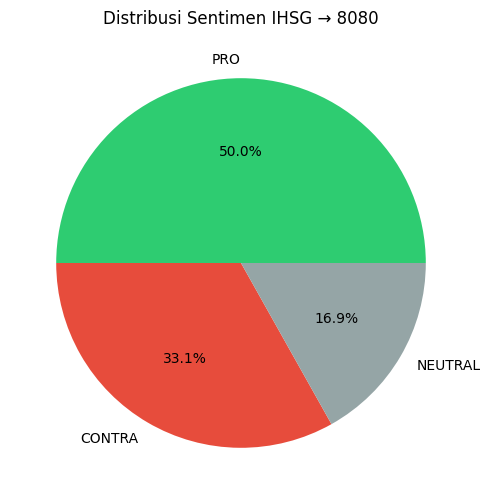

In [ ]:
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
from google.colab import userdata
import re
from urllib.parse import urlparse, parse_qs
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from langchain_community.llms import Replicate
import os

warnings.filterwarnings('ignore')

# ----------------------------
# 1. SETUP YouTube & Granite
# ----------------------------
def setup_youtube_api():
    key = userdata.get('YOUTUBE_API')
    if not key:
        raise RuntimeError("YOUTUBE_API missing in Colab Secrets")
    return build('youtube', 'v3', developerKey=key)

def setup_granite_model():
    token = userdata.get('REPLICATE_API_TOKEN')
    if not token:
        raise RuntimeError("REPLICATE_API_TOKEN missing in Colab Secrets")
    os.environ["REPLICATE_API_TOKEN"] = token
    return Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        replicate_api_token=token,
        model_kwargs={"temperature":0.1, "max_new_tokens":60, "top_p":0.9, "repetition_penalty":1.0}
    )

youtube = setup_youtube_api()
granite_llm = setup_granite_model()

# ------------------------------------
# 2. EXTRACT & VALIDATE YouTube video
# ------------------------------------
def extract_video_id(url):
    if not url: return None
    if url.startswith(('youtu', 'www')): url = 'https://' + url
    q = urlparse(url)
    if 'youtube.com' in q.netloc:
        if q.path == '/watch':
            return parse_qs(q.query).get('v',[None])[0]
        return q.path.split('/')[2]
    if 'youtu.be' in q.netloc:
        return q.path[1:]
    m = re.search(r"(?:v=|/)([\w\-]{11})", url)
    return m.group(1) if m else None

def validate_video_id(video_id):
    resp = youtube.videos().list(part='snippet,statistics', id=video_id).execute()
    if not resp['items']:
        return False, None, 0
    info = resp['items'][0]
    return True, info['snippet']['title'], int(info['statistics'].get('commentCount',0))

# -----------------------------------
# 3. PAGINATED COMMENT EXTRACTION
# -----------------------------------
def get_comments(video_id, max_comments):
    comments, token = [], None
    while len(comments) < max_comments:
        batch = min(100, max_comments - len(comments))
        res = youtube.commentThreads().list(
            part='snippet', videoId=video_id,
            maxResults=batch, pageToken=token,
            textFormat='plainText', order='relevance'
        ).execute()
        for it in res['items']:
            s = it['snippet']['topLevelComment']['snippet']
            comments.append({
                'video_id': video_id,
                'comment_id': it['snippet']['topLevelComment']['id'],
                'comment': s['textDisplay'],
                'author': s['authorDisplayName'],
                'published_at': s['publishedAt'],
                'like_count': s['likeCount']
            })
        token = res.get('nextPageToken')
        if not token: break
        time.sleep(0.1)
    return comments

def get_multiple_comments(urls, target=4500):
    allc, vids = [], []
    for u in urls:
        vid = extract_video_id(u)
        ok, _, count = validate_video_id(vid) if vid else (False,None,0)
        if not ok: continue
        need = min(target - len(allc), count)
        if need<=0: break
        c = get_comments(vid, need)
        allc += c
        vids.append(vid)
        if len(allc)>=target: break
        time.sleep(1)
    return pd.DataFrame(allc), vids

# ---------------------------------------------------
# 4. PROMPT & CLASSIFY WITH IBM Granite (Replicate)
# ---------------------------------------------------
def classify_sentiment(comment, llm):
    txt = comment.replace('\n',' ')[:400]
    prompt = f"""
Anda adalah model untuk mengklasifikasikan sentimen komentar YouTube terkait prediksi IHSG mencapai 8080 sebelum 17 Agustus 2025.
Komentar: "{txt}"
Tugas: Pilih satu dari PRO, CONTRA, NEUTRAL.
− PRO: optimis IHSG tembus 8080 sebelum HUT RI.
− CONTRA: pesimis IHSG tembus 8080.
− NEUTRAL: tidak relevan atau netral.
Jawab hanya kata kunci!"""
    out = llm.invoke(prompt).strip().upper()
    if 'PRO' in out: return 'PRO'
    if 'CONTRA' in out or 'BEARISH' in out: return 'CONTRA'
    return 'NEUTRAL'

def analyze_batch(df, llm, batch_size=50):
    results = []
    for c in tqdm(df['comment'], desc="Klasifikasi"):
        try:
            results.append(classify_sentiment(c, llm))
            time.sleep(1.2)
        except:
            results.append('NEUTRAL')
    df['sentiment'] = results
    return df

# ----------------------------
# 5. VISUALIZATION & REPORT
# ----------------------------
def visualize(df):
    counts = df['sentiment'].value_counts()
    colors = {'PRO':'#2ecc71','CONTRA':'#e74c3c','NEUTRAL':'#95a5a6'}
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
            colors=[colors[k] for k in counts.index])
    plt.title("Distribusi Sentimen IHSG → 8080")
    plt.show()

# ----------------------------
# 6. MAIN WORKFLOW
# ----------------------------
def main_workflow(video_urls):
    df, vids = get_multiple_comments(video_urls, target=4500)
    df = df[df['comment'].str.len()>=10].drop_duplicates('comment')
    df = analyze_batch(df, granite_llm)
    visualize(df)
    df.to_csv('ihsg_sentiment_4500.csv', index=False)
    return df

# USAGE:
urls = [
    "https://youtu.be/wYtvewS_Dlo",
    "https://youtu.be/G_gZ9nvfJBg",
    "https://youtu.be/QC6PPJQV94U",
    "https://www.youtube.com/watch?v=RXPiHqwjVSg",
    # tambahkan lebih banyak hingga total target
]
result_df = main_workflow(urls)


Klasifikasi: 100%|██████████| 2633/2633 [54:40<00:00,  1.25s/it]


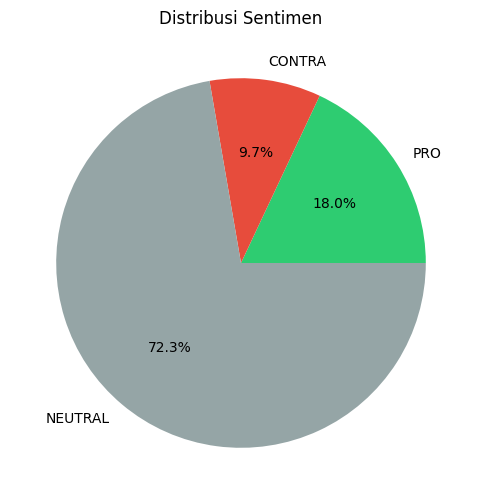

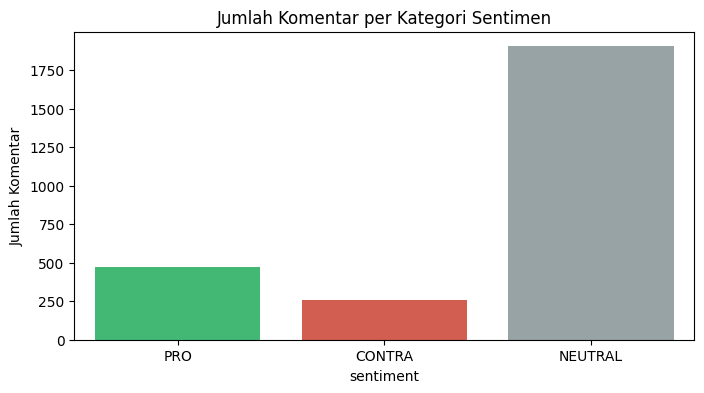

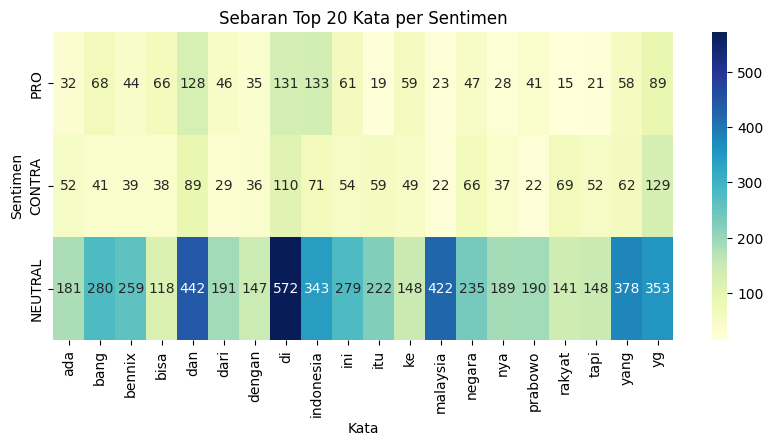

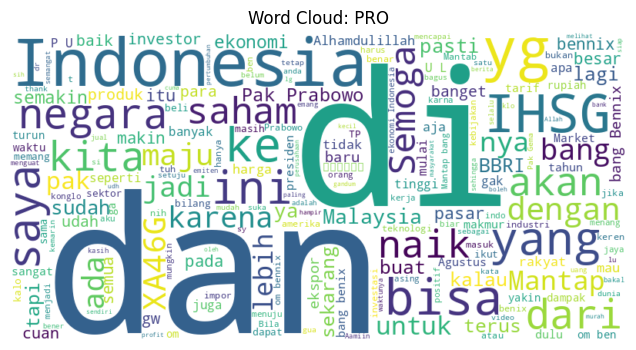

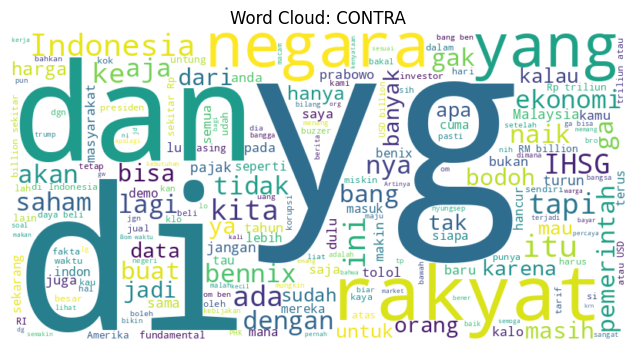

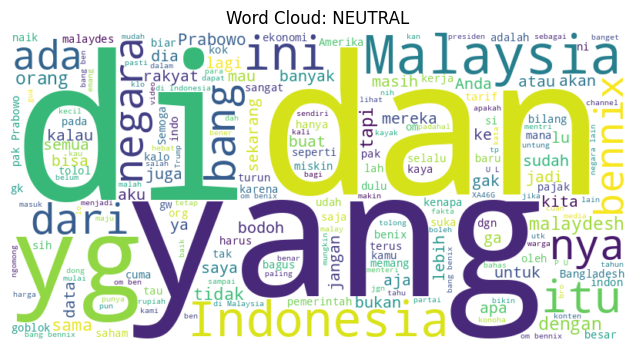

In [ ]:
import pandas as pd
import re
import time
import os
from urllib.parse import urlparse, parse_qs
from googleapiclient.discovery import build
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_community.llms import Replicate

def setup_youtube_api():
    key = userdata.get('YOUTUBE_API')
    if not key:
        raise RuntimeError("YOUTUBE_API missing in Colab Secrets")
    return build('youtube', 'v3', developerKey=key)

def setup_granite():
    token = os.getenv('REPLICATE_API_TOKEN')
    if not token:
        raise RuntimeError('REPLICATE_API_TOKEN missing')
    os.environ['REPLICATE_API_TOKEN'] = token
    return Replicate(
        model='ibm-granite/granite-3.3-8b-instruct',
        replicate_api_token=token,
        model_kwargs={
            'temperature': 0.01,
            'max_new_tokens': 12,
            'top_p': 0.5,
            'repetition_penalty': 1.2
        }
    )

youtube = setup_youtube_api()
granite = setup_granite()

def extract_id(url):
    if url.startswith(('youtu', 'www')):
        url = 'https://' + url
    p = urlparse(url)
    if 'youtu.be' in p.netloc:
        return p.path.lstrip('/')
    if 'youtube.com' in p.netloc:
        if p.path == '/watch':
            return parse_qs(p.query).get('v', [None])[0]
        return p.path.split('/')[-1]
    m = re.search(r'(?:v=|/)([\w\-]{11})', url)
    return m.group(1) if m else None

def validate(video_id):
    r = youtube.videos().list(part='statistics', id=video_id).execute()
    items = r.get('items', [])
    return bool(items), int(items[0]['statistics'].get('commentCount', 0)) if items else 0

def fetch_comments(vid, limit):
    comments, page = [], None
    while len(comments) < limit:
        batch = min(100, limit - len(comments))
        resp = youtube.commentThreads().list(
            part='snippet', videoId=vid, maxResults=batch,
            pageToken=page, textFormat='plainText'
        ).execute()
        for itm in resp.get('items', []):
            s = itm['snippet']['topLevelComment']['snippet']
            comments.append({'id': itm['snippet']['topLevelComment']['id'], 'text': s['textDisplay']})
        page = resp.get('nextPageToken')
        if not page:
            break
        time.sleep(0.1)
    return comments

def classify(text):
    snippet = text.replace('\n', ' ')[:300]
    prompt = f"""
INSTRUKSI:
Diberikan satu komentar pada kolom “Komentar:”.

Tugas Anda:

Pilih salah satu dari tiga kategori berikut, dan jawablah hanya dengan kata kunci kategori tersebut (tanpa penjelasan tambahan).
– PRO: Optimis atau setuju bahwa IHSG akan atau berpotensi menembus 8080 sebelum HUT RI.
– CONTRA: Pesimis atau meragukan bahwa IHSG akan menembus 8080 sebelum HUT RI.
– NEUTRAL: Tidak membahas sentimen positif/negatif terhadap prediksi IHSG ke 8080; komentar ambigu, bercanda, atau tidak relevan.

Komentar: "{snippet}"

Catatan:
– Jawab hanya dengan: PRO, CONTRA, atau NEUTRAL.
– Jangan ulangi teks komentar.
– Jangan menambahkan penjelasan atau alasan apapun."""
    out = granite.invoke(prompt).strip().upper()
    if 'PRO' in out:
        return 'PRO'
    if 'CONTRA' in out:
        return 'CONTRA'
    return 'NEUTRAL'

def process(videos, target=4500):
    all_comments = []
    for url in videos:
        vid = extract_id(url)
        ok, count = validate(vid) if vid else (False, 0)
        if not ok:
            continue
        needed = min(target - len(all_comments), count)
        if needed <= 0:
            break
        all_comments.extend(fetch_comments(vid, needed))
        if len(all_comments) >= target:
            break
        time.sleep(1)

    df = pd.DataFrame(all_comments).drop_duplicates('text')
    df = df[df['text'].str.len() >= 10].reset_index(drop=True)

    sentiments = []
    for text in tqdm(df['text'], desc='Klasifikasi'):
        sentiments.append(classify(text))
        time.sleep(0.5)
    df['sentiment'] = sentiments

    # 1. Pie chart of sentiment distribution
    counts = df['sentiment'].value_counts().reindex(['PRO','CONTRA','NEUTRAL']).fillna(0)
    colors = {'PRO': '#2ecc71', 'CONTRA': '#e74c3c', 'NEUTRAL': '#95a5a6'}
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=[colors[k] for k in counts.index])
    plt.title('Distribusi Sentimen')
    plt.show()

    # 2. Bar chart
    plt.figure(figsize=(8,4))
    sns.barplot(x=counts.index, y=counts.values, palette=[colors[k] for k in counts.index])
    plt.title('Jumlah Komentar per Kategori Sentimen')
    plt.ylabel('Jumlah Komentar')
    plt.show()

    # 3. Heatmap of word counts vs sentiment
    # Create term-document matrix for top 20 words
    from sklearn.feature_extraction.text import CountVectorizer
    vect = CountVectorizer(stop_words='english', max_features=20)
    X = vect.fit_transform(df['text'])
    td = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    td['sentiment'] = df['sentiment']
    grouped = td.groupby('sentiment').sum().reindex(['PRO','CONTRA','NEUTRAL'])

    plt.figure(figsize=(10,4))
    sns.heatmap(grouped, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Sebaran Top 20 Kata per Sentimen')
    plt.ylabel('Sentimen')
    plt.xlabel('Kata')
    plt.show()

    # 4. Word cloud per sentiment
    from wordcloud import WordCloud
    for cat in ['PRO','CONTRA','NEUTRAL']:
        text_cat = ' '.join(df.loc[df['sentiment']==cat, 'text'])
        wc = WordCloud(width=800, height=400, background_color='white').generate(text_cat)
        plt.figure(figsize=(8,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud: {cat}')
        plt.show()

    df.to_csv('ihsg_sentiment.csv', index=False)
    return df

urls = [
    'https://youtu.be/wYtvewS_Dlo',
    'https://youtu.be/G_gZ9nvfJBg',
    'https://youtu.be/QC6PPJQV94U',
    'https://youtu.be/RXPiHqwjVSg',
    'https://youtu.be/QC6PPJQV94U?si=JkIXSkmgDq1fuevb',
    'https://www.youtube.com/live/AQ5mHU9dbpw?si=Z-vL4tIlJwbQQq-R'
]
result = process(urls, target=4500)

Klasifikasi:   0%|          | 0/2483 [00:00<?, ?it/s]

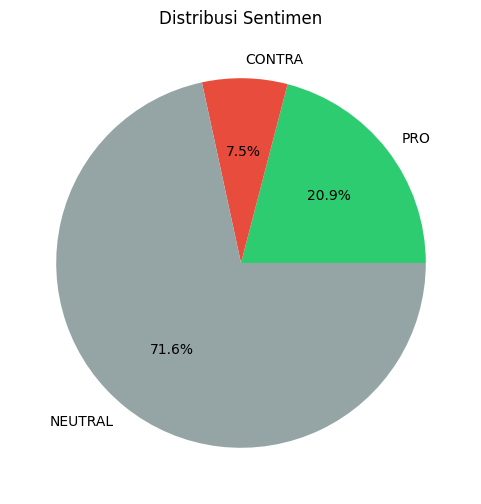

Klasifikasi:   4%|▍         | 97/2541 [2:33:46<64:34:34, 95.12s/it]


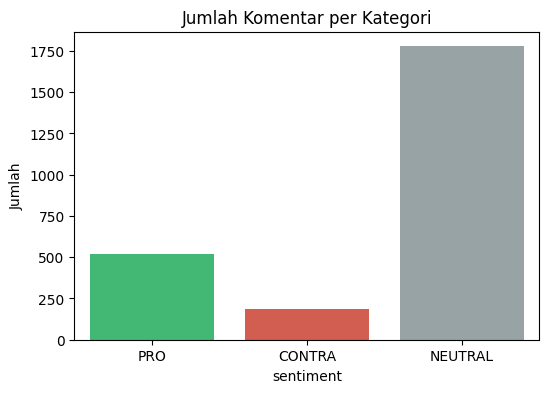

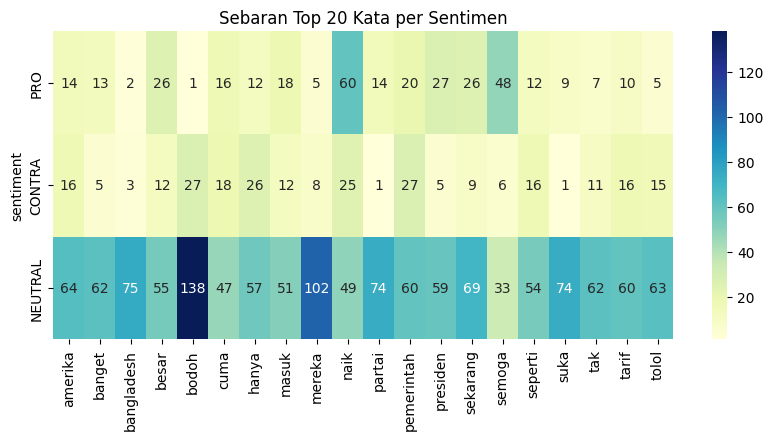

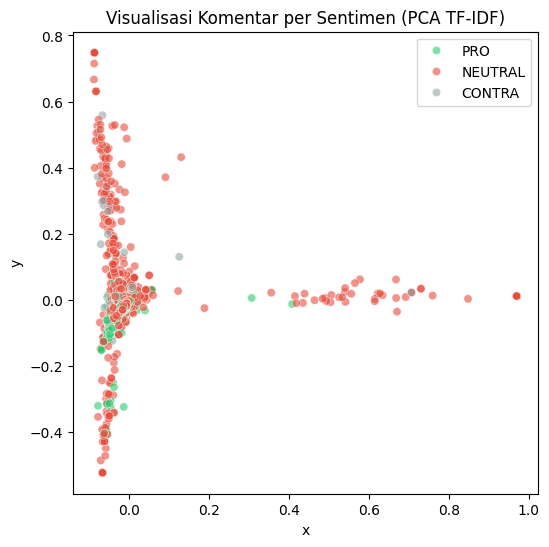

In [ ]:
import pandas as pd
import re
import time
import os
from urllib.parse import urlparse, parse_qs
from googleapiclient.discovery import build
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from langchain_community.llms import Replicate

# Daftar stopwords Bahasa Indonesia
STOPWORDS_ID = {
    'adalah', 'adapun', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya',
    'aku', 'amat', 'anda', 'antar', 'antara', 'antaranya', 'apa', 'apakah',
    'apalagi', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'atau–kah', 'ataupun',
    'awal', 'awalnya', 'bagai', 'bagaimana', 'bagaimanapun', 'bagi', 'bagian',
    'bahkan', 'bahwa', 'baik', 'bakal', 'banyak', 'baru', 'bawah', 'beberapa',
    'begini', 'begitu', 'begitupun', 'bekerja', 'belakang', 'belum', 'benar',
    'berada', 'berakhir', 'berapa', 'berarti', 'berbagai', 'bersama', 'besok',
    'bisa', 'boleh', 'buat', 'bukan', 'bulan', 'bung', 'cara', 'cukup', 'cukupkah',
    'dalam', 'dan', 'dapat', 'dari', 'datang', 'dekat', 'demi', 'demikian',
    'demikianlah', 'depan', 'di', 'dia', 'diberi', 'diberikan', 'dibuat',
    'didapat', 'digunakan', 'diibaratkan', 'diingat', 'dijawab', 'dijelaskan',
    'diketahui', 'dilakukan', 'dimaksud', 'diminta', 'dipakai', 'dipastikan',
    'diperkirakan', 'ditambahkan', 'ditanya', 'ditunjuk', 'ditunjukkan', 'dituturkan',
    'dua', 'dulu', 'empat', 'enggak', 'guna', 'harus', 'harusnya', 'hingga',
    'ia', 'ialah', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi',
    'jangan', 'jauhh', 'jawab', 'jelas', 'jika', 'ingat', 'ingin', 'juga',
    'karena', 'kapan', 'karenanya', 'kasus', 'kata', 'kecuali', 'keduanya',
    'keluar', 'kembali', 'kemudian', 'kenapa', 'kepada', 'ketika', 'khususnya',
    'kini', 'kira', 'kita', 'kok', 'kurang', 'lagi', 'lalu', 'lama', 'langsung',
    'lain', 'laporan', 'lebih', 'Lewat', 'luar', 'macam', 'maka', 'makanya',
    'malah', 'mana', 'masalah', 'masih', 'masing', 'masing-masing', 'mata',
    'menjadi', 'menjawab', 'menjelaskan', 'menuju', 'merupakan', 'meskipun',
    'mesti', 'metode', 'mula', 'mulai', 'mungkin', 'nanti', 'nya', 'oleh',
    'pada', 'padahal', 'panduan', 'para', 'per', 'perlu', 'pernah', 'pertama',
    'pertanyaan', 'pihak', 'poin', 'pola', 'pun', 'putus', 'rasa', 'rata',
    'realita', 'realitas', 'saat', 'saja', 'salah', 'saling', 'sama', 'sangat',
    'saya', 'secara', 'sedang', 'sedangkan', 'sedikit', 'seenaknya', 'segala',
    'seharusnya', 'sehingga', 'selain', 'selalu', 'selama', 'selanjutnya',
    'seluruh', 'semakin', 'semampu', 'semasa', 'sementara', 'semisal', 'semua',
    'sendiri', 'seolah', 'sering', 'serta', 'sesaat', 'sesegera', 'sesuai',
    'sesungguhnya', 'setelah', 'setiap', 'setidaknya', 'setinggi', 'siapa',
    'silakan', 'sistem', 'suatu', 'sudah', 'sudahlah', 'supaya', 'tadi', 'tahu',
    'tapi', 'tegas', 'telah', 'terakhir', 'terasa', 'terdapat', 'terhadap',
    'terjadi', 'terlihat', 'termasuk', 'ternyata', 'tersebut', 'terutama',
    'terus', 'tetapi', 'tiap', 'tiba', 'tidak', 'tiga', 'tolong', 'tutup',
    'turut', 'tuturnya', 'ucap', 'ujar', 'untuk', 'untung', 'usai', 'waduh',
    'wahai', 'waktu', 'wang', 'yakni', 'yang', 'ya', 'yakin', 'bang', 'bennix',
    'ben', 'benix',    'ada','aja','data','dengan','ekonomi','gak','ihsg','indonesia',
    'kalau','malaydesh','malaysia','mau','negara','orang','pak',
    'prabowo','rakyat','saham'
}

def clean_text(text):
    txt = text.lower()
    txt = re.sub(r'https?://\S+', ' ', txt)
    txt = re.sub(r'[@#]\w+', ' ', txt)
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    tokens = [w for w in txt.split() if w not in STOPWORDS_ID and len(w) > 2]
    return ' '.join(tokens)

def setup_youtube_api():
    key = userdata.get('YOUTUBE_API')
    if not key:
        raise RuntimeError("YOUTUBE_API missing in Colab Secrets")
    return build('youtube', 'v3', developerKey=key)

def setup_granite():
    token = os.getenv('REPLICATE_API_TOKEN')
    if not token:
        raise RuntimeError('REPLICATE_API_TOKEN missing')
    os.environ['REPLICATE_API_TOKEN'] = token
    return Replicate(
        model='ibm-granite/granite-3.3-8b-instruct',
        replicate_api_token=token,
        model_kwargs={
            'temperature': 0.01,
            'max_new_tokens': 12,
            'top_p': 0.5,
            'repetition_penalty': 1.2
        }
    )

youtube = setup_youtube_api()
granite = setup_granite()

def extract_id(url):
    if url.startswith(('youtu', 'www')):
        url = 'https://' + url
    p = urlparse(url)
    if 'youtu.be' in p.netloc:
        return p.path.lstrip('/')
    if 'youtube.com' in p.netloc:
        if p.path == '/watch':
            return parse_qs(p.query).get('v', [None])[0]
        return p.path.split('/')[-1]
    m = re.search(r'(?:v=|/)([\w\-]{11})', url)
    return m.group(1) if m else None

def validate(video_id):
    r = youtube.videos().list(part='statistics', id=video_id).execute()
    items = r.get('items', [])
    return bool(items), int(items[0]['statistics'].get('commentCount', 0)) if items else 0

def fetch_comments(vid, limit):
    comments, page = [], None
    while len(comments) < limit:
        batch = min(100, limit - len(comments))
        resp = youtube.commentThreads().list(
            part='snippet', videoId=vid, maxResults=batch,
            pageToken=page, textFormat='plainText'
        ).execute()
        for itm in resp.get('items', []):
            s = itm['snippet']['topLevelComment']['snippet']
            comments.append({'id': itm['id'], 'text': s['textDisplay']})
        page = resp.get('nextPageToken')
        if not page:
            break
        time.sleep(0.1)
    return comments

def classify(text):
    snippet = text.replace('\n', ' ')[:300]
    prompt = f"""
Anda adalah model klasifikasi sentimen komentar YouTube terkait prediksi IHSG menembus angka 8080 sebelum 17 Agustus 2025.

INSTRUKSI:
Diberikan satu komentar pada kolom “Komentar:”.


Tugas Anda:

Pilih salah satu dari tiga kategori berikut, dan jawablah hanya dengan kata kunci kategori tersebut (tanpa penjelasan tambahan).
– PRO: Optimis atau setuju bahwa IHSG akan atau berpotensi menembus 8080 sebelum HUT RI.
– CONTRA: Pesimis atau meragukan bahwa IHSG akan menembus 8080 sebelum HUT RI.
– NEUTRAL: Tidak membahas sentimen positif/negatif terhadap prediksi IHSG ke 8080; komentar ambigu, bercanda, atau tidak relevan.

Komentar: "{snippet}"

Catatan:
– Jawab hanya dengan: PRO, CONTRA, atau NEUTRAL.
– Jangan ulangi teks komentar.
– Jangan menambahkan penjelasan atau alasan apapun."""
    out = granite.invoke(prompt).strip().upper()
    if 'PRO' in out:
        return 'PRO'
    if 'CONTRA' in out:
        return 'CONTRA'
    return 'NEUTRAL'

def process(videos, target=4500):
    all_comments = []
    for url in videos:
        vid = extract_id(url)
        ok, count = validate(vid) if vid else (False, 0)
        if not ok:
            continue
        needed = min(target - len(all_comments), count)
        if needed <= 0:
            break
        all_comments.extend(fetch_comments(vid, needed))
        time.sleep(1)

    df = pd.DataFrame(all_comments).drop_duplicates('text')
    df['clean'] = df['text'].map(clean_text)
    df = df[df['clean'].str.len() >= 10].reset_index(drop=True)

    # Klasifikasi dengan tqdm notebook
    df['sentiment'] = [
        classify(t)
        for t in tqdm(df['clean'], desc='Klasifikasi', ncols=80, ascii=True, dynamic_ncols=True)
    ]
    df.to_csv('ihsg_sentiment.csv', index=False)

    # Visualisasi
    counts = df['sentiment'].value_counts().reindex(['PRO','CONTRA','NEUTRAL']).fillna(0)
    colors = ['#2ecc71','#e74c3c','#95a5a6']
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Distribusi Sentimen'); plt.show()

    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette=colors)
    plt.title('Jumlah Komentar per Kategori'); plt.ylabel('Jumlah'); plt.show()

    vect = CountVectorizer(max_features=20)
    X = vect.fit_transform(df['clean'])
    td = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    td['sentiment'] = df['sentiment']
    grp = td.groupby('sentiment').sum().reindex(['PRO','CONTRA','NEUTRAL'])
    plt.figure(figsize=(10,4))
    sns.heatmap(grp, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Sebaran Top 20 Kata per Sentimen'); plt.show()

    tfidf = TfidfVectorizer(max_features=200)
    Xtf = tfidf.fit_transform(df['clean']).toarray()
    pca = PCA(n_components=2).fit_transform(Xtf)
    plt.figure(figsize=(6,6))
    df['x'], df['y'] = pca[:,0], pca[:,1]
    sns.scatterplot(data=df, x='x', y='y', hue='sentiment', palette=colors, alpha=0.6)
    plt.title('Visualisasi Komentar per Sentimen (PCA TF-IDF)'); plt.legend(); plt.show()

    return df

# Contoh pemanggilan
urls = [
    'https://youtu.be/wYtvewS_Dlo',
    'https://youtu.be/G_gZ9nvfJBg',
    'https://youtu.be/QC6PPJQV94U',
    'https://youtu.be/RXPiHqwjVSg',
    'https://youtu.be/QC6PPJQV94U?si=JkIXSkmgDq1fuevb',
    'https://www.youtube.com/live/AQ5mHU9dbpw?si=Z-vL4tIlJwbQQq-R'
]
result = process(urls, target=4500)


In [ ]:
!pip install langchain_community tqdm matplotlib seaborn scikit-learn


In [ ]:
pip install replicate

In [ ]:
import pandas as pd
import re
import time
import os
from urllib.parse import urlparse, parse_qs
from googleapiclient.discovery import build
from tqdm.notebook import tqdm
from google.colab import userdata

# --- Konfigurasi API ---
def setup_youtube_api():
    key = userdata.get('YOUTUBE_API')
    if not key:
        raise RuntimeError("YOUTUBE_API missing in Colab Secrets")
    return build('youtube', 'v3', developerKey=key)

# --- Helper fungsi YouTube ---
def extract_id(url):
    if url.startswith(('youtu', 'www')):
        url = 'https://' + url
    p = urlparse(url)
    if 'youtu.be' in p.netloc:
        return p.path.lstrip('/')
    if 'youtube.com' in p.netloc:
        if p.path == '/watch':
            return parse_qs(p.query).get('v', [None])[0]
        return p.path.split('/')[-1]
    m = re.search(r'(?:v=|/)([\w\-]{11})', url)
    return m.group(1) if m else None

def validate(video_id, youtube):
    r = youtube.videos().list(part='statistics', id=video_id).execute()
    items = r.get('items', [])
    return bool(items), int(items[0]['statistics'].get('commentCount', 0)) if items else 0

def fetch_comments(vid, limit, youtube):
    comments, page = [], None
    while len(comments) < limit:
        batch = min(100, limit - len(comments))
        resp = youtube.commentThreads().list(
            part='snippet', videoId=vid, maxResults=batch,
            pageToken=page, textFormat='plainText'
        ).execute()
        for itm in resp.get('items', []):
            s = itm['snippet']['topLevelComment']['snippet']
            comments.append({'id': itm['id'], 'text': s['textDisplay']})
        page = resp.get('nextPageToken')
        if not page:
            break
        time.sleep(0.1)
    return comments

def crawl_and_save_csv(urls, target=4500, out_csv='yt_comments.csv'):
    youtube = setup_youtube_api()
    all_comments = []
    for url in urls:
        vid = extract_id(url)
        ok, count = validate(vid, youtube) if vid else (False, 0)
        if not ok: continue
        needed = min(target - len(all_comments), count)
        if needed <= 0: break
        all_comments.extend(fetch_comments(vid, needed, youtube))
        time.sleep(1)
    df = pd.DataFrame(all_comments).drop_duplicates('text')
    df.to_csv(out_csv, index=False)
    print(f'Saved {len(df)} comments to {out_csv}')
    return out_csv

# ---- PEMANGGILAN ----
urls = [
    'https://youtu.be/wYtvewS_Dlo',
    'https://youtu.be/G_gZ9nvfJBg',
    'https://youtu.be/QC6PPJQV94U',
    'https://youtu.be/RXPiHqwjVSg',
    'https://youtu.be/QC6PPJQV94U?si=JkIXSkmgDq1fuevb',
    'https://www.youtube.com/live/AQ5mHU9dbpw?si=Z-vL4tIlJwbQQq-R',
    'https://youtu.be/CBg9rPJZoOo?si=piWp-bnVkI24LOjb'
]
crawl_and_save_csv(urls, target=4500, out_csv='yt_comments.csv')

Saved 2753 comments to yt_comments.csv


'yt_comments.csv'

Klasifikasi:   0%|          | 0/2465 [00:00<?, ?it/s]

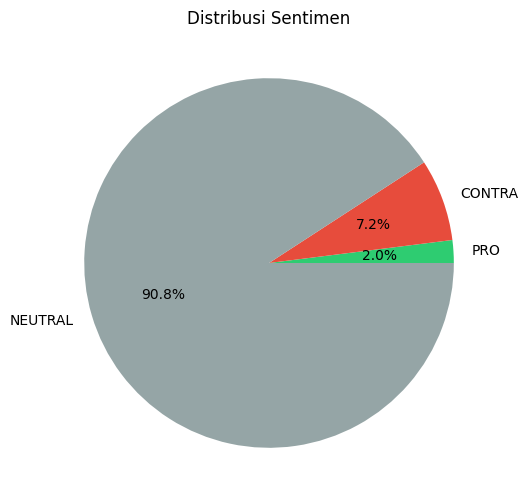

/tmp/ipython-input-268420046.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=colors)


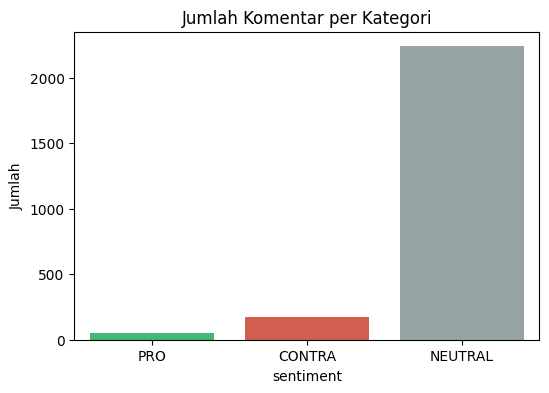

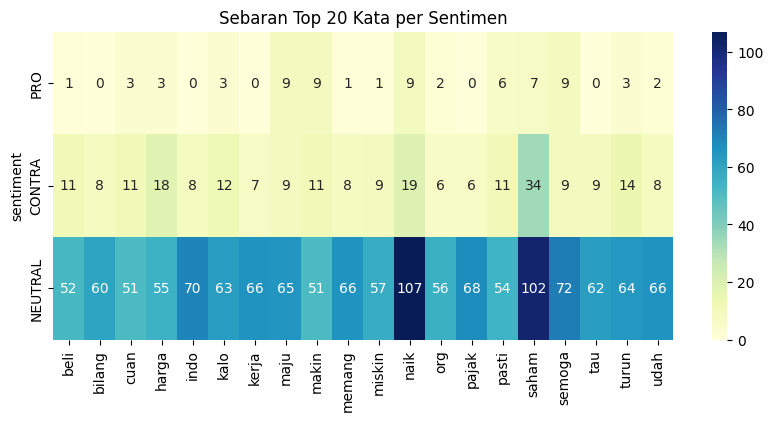

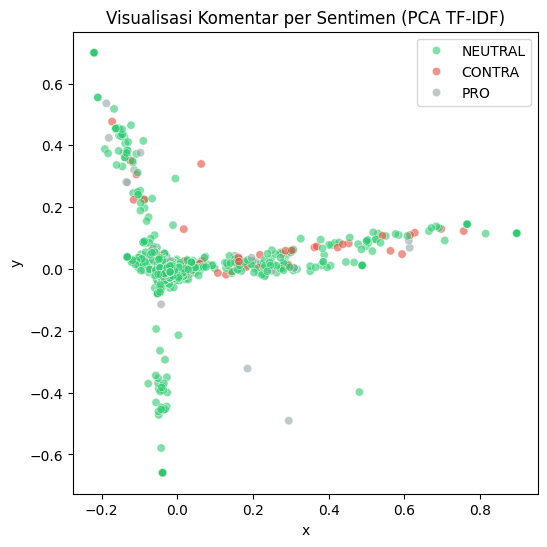

,id,text,clean,sentiment,x,y
0,UgzBexFS8rFPu_81tbF4AaABAg,"Benar om bennix, suami sy kerja dimanufaktur p...",suami kerja dimanufaktur produk ekspor lgs lem...,NEUTRAL,-0.027046,0.027881
1,UgycDUMuKQ0O9r6M6nJ4AaABAg,Udh 8000 selamat,udh selamat,NEUTRAL,-0.018936,-0.009712
2,UgxSz7YrgmvloZCcpWZ4AaABAg,Ini org BYK koyal😂😂,org byk koyal,NEUTRAL,-0.040070,-0.005907
3,Ugzer5YQkvN2AK-fENZ4AaABAg,"Malaysia tidak import kekacang, kerana Malaysi...",import kekacang kerana maju import cip bertekn...,NEUTRAL,-0.024402,0.026226
4,UgykGpDVxI3DifyjEHd4AaABAg,Bennix Alhamdulillah Indon dah maju lo panggil...,alhamdulillah indon dah maju panggil warga ind...,NEUTRAL,-0.059608,0.025683
...,...,...,...,...,...,...
2460,UgxoXTM2M3i_f9OoNyN4AaABAg,Terima kasih astronacci❤ \nArigato money\nYang...,terima kasih astronacci arigato money katain m...,NEUTRAL,-0.050512,-0.017232
2461,UgzZoKIJGLUOqMG7EFx4AaABAg,Saya untung pak makasih di bbri tapi whatsapp ...,makasih bbri whatsapp aclub aktif,NEUTRAL,-0.019244,0.009341
2462,UgyJpupp7ZbI-nyw9u54AaABAg,Ishg all time high. Ishg kembali ke 7900 an. O...,ishg all time high ishg ojk tentu senang banda...,PRO,0.196403,0.036056
2463,UgwVkaKiBUgvwyx75Wd4AaABAg,Ancur suaranya..,ancur suaranya,NEUTRAL,-0.018936,-0.009712


In [ ]:
!pip install langchain_community tqdm matplotlib seaborn scikit-learn replicate

import pandas as pd
import re
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from langchain_community.llms import Replicate
from google.colab import userdata
import replicate

STOPWORDS_ID = {
    'adalah', 'adapun', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya',
'aku', 'amat', 'anda', 'antar', 'antara', 'antaranya', 'apa', 'apakah', 'apalagi',
'artinya', 'asal', 'asalkan', 'atas', 'atau', 'atau–kah', 'ataupun', 'awal', 'awalnya',
'bagai', 'bagaimana', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'baik',
'bakal', 'banyak', 'baru', 'bawah', 'beberapa', 'begini', 'begitu', 'begitupun',
'bekerja', 'belakang', 'belum', 'benar', 'berada', 'berakhir', 'berapa', 'berarti',
'berbagai', 'bersama', 'besok', 'bisa', 'boleh', 'buat', 'bukan', 'bulan', 'bung',
'cara', 'cukup', 'cukupkah', 'dalam', 'dan', 'dapat', 'dari', 'datang', 'dekat',
'demi', 'demi­kian', 'demikianlah', 'depan', 'di', 'dia', 'diberi', 'diberikan',
'dibuat', 'didapat', 'digunakan', 'diibaratkan', 'diingat', 'dijawab', 'dijelaskan',
'diketahui', 'dilakukan', 'dimaksud', 'diminta', 'dipakai', 'dipastikan', 'diperkirakan',
'ditambahkan', 'ditanya', 'ditunjuk', 'ditunjukkan', 'dituturkan', 'dua', 'dulu',
'empat', 'enggak', 'guna', 'harus', 'harusnya', 'hingga', 'ia', 'ialah', 'ini',
'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jangan', 'jawab', 'jelas',
'jika', 'ingat', 'ingin', 'juga', 'karena', 'kapan', 'karenanya', 'kasus', 'kata',
'kecuali', 'keduanya', 'kembali', 'kemudian', 'kenapa', 'kepada', 'ketika',
'khususnya', 'kini', 'kira', 'kita', 'kok', 'kurang', 'lagi', 'lalu', 'lama',
'langsung', 'lain', 'laporan', 'lebih', 'lewat', 'luar', 'macam', 'maka', 'makanya',
'malah', 'mana', 'masalah', 'masih', 'masing', 'mata', 'menjadi', 'menjawab',
'menjelaskan', 'menuju', 'merupakan', 'meskipun', 'mesti', 'metode', 'mula',
'mulai', 'mungkin', 'nanti', 'nya', 'oleh', 'pada', 'padahal', 'para', 'per',
'perlu', 'pernah', 'pertama', 'pertanyaan', 'pihak', 'poin', 'pola', 'pun', 'putus',
'rasa', 'rata', 'realita', 'realitas', 'saat', 'saja', 'salah', 'saling', 'sama',
'sangat', 'saya', 'secara', 'sedang', 'sedangkan', 'sedikit', 'seenaknya', 'segala',
'seharusnya', 'sehingga', 'selain', 'selalu', 'selama', 'selanjutnya', 'seluruh',
'semakin', 'semampu', 'semasa', 'sementara', 'semisal', 'semua', 'sendiri', 'seolah',
'sering', 'serta', 'sesaat', 'sesegera', 'sesuai', 'sesungguhnya', 'setelah',
'setiap', 'setidaknya', 'setinggi', 'siapa', 'silakan', 'sistem', 'suatu', 'sudah',
'sudahlah', 'supaya', 'tadi', 'tahu', 'tapi', 'tegas', 'telah', 'terakhir', 'terasa',
'terdapat', 'terhadap', 'terjadi', 'terlihat', 'termasuk', 'ternyata', 'tersebut',
'terutama', 'terus', 'tetapi', 'tiap', 'tiba', 'tidak', 'tiga', 'tolong', 'tutup',
'turut', 'tuturnya', 'ucap', 'ujar', 'untuk', 'untung', 'usai', 'waduh', 'wahai',
'waktu', 'wang', 'yakni', 'yang', 'ya', 'yakin','amerika','bangladesh','presiden',
'partai','pemerintah','mereka','cuma','hanya','sekarang','banget','besar','besat',
'emang', 'heboh', 'wkwk', 'wkwkwk', 'eh', 'gitu', 'nih', 'tuh', 'sih',
'bang', 'bennix',
'ben', 'benix',    'ada','aja','data','dengan','ekonomi','gak','ihsg','indonesia',
'kalau','malaydesh','malaysia','mau','negara','orang','pak',
'prabowo','rakyat','saham'
'yaudahlah', 'cobain', 'langsung', 'tadi', 'sama', 'sekalian', 'sayang',
'thank', 'thx', 'tq', 'btw', 'ok', 'sip', 'haha', '😂', '🤣', '😅',
'america', 'banget', 'bangladesh', 'besar', 'bodoh',
'cuma', 'hanya', 'masuk', 'mereka', 'partai',
'pemerintah', 'presiden', 'sekarang',
'seperti', 'suka', 'tak', 'tarif', 'tolol'

}

def clean_text(text):
    txt = text.lower()
    txt = re.sub(r'https?://\S+', ' ', txt)
    txt = re.sub(r'[@#]\w+', ' ', txt)
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    tokens = [w for w in txt.split() if w not in STOPWORDS_ID and len(w) > 2]
    return ' '.join(tokens)

def setup_granite():
    token = userdata.get('REPLICATE_API_TOKEN')
    if not token:
        raise RuntimeError('REPLICATE_API_TOKEN missing in Colab Secrets')
    os.environ['REPLICATE_API_TOKEN'] = token
    return Replicate(
        model='ibm-granite/granite-3.3-8b-instruct',
        replicate_api_token=token,
        model_kwargs={
            'temperature': 0.01,
            'max_new_tokens': 12,
            'top_p': 0.5,
            'repetition_penalty': 1.2
        }
    )

def classify(text, granite):
    snippet = text.replace('\n', ' ')[:300]
    prompt = f"""
[PERAN DAN KONTEKS]
Anda adalah model klasifikasi sentimen yang sangat akurat, dilatih khusus untuk komentar investor di YouTube. Tugas Anda adalah menganalisis komentar YouTube terkait prediksi IHSG (Indeks Harga Saham Gabungan) akan menembus 8080 sebelum 17 Agustus 2025.

[TUGAS]
Klasifikasikan komentar berikut ke dalam salah satu dari 3 kategori di bawah.

[DEFINISI KATEGORI]
- PRO: Komentar optimis, percaya, mendukung, atau setuju IHSG akan tembus 8080 sebelum HUT RI.
- CONTRA: Komentar pesimis, tidak percaya, meragukan, atau menolak IHSG tembus 8080 sebelum HUT RI.
- NEUTRAL: Komentar yang tidak mengandung pendapat jelas, tidak relevan, ambigu, bertanya, atau hanya menyatakan fakta tanpa sikap.

[CONTOH KLASIFIKASI]
- Komentar: "Gaskeun lah 8080 optimis!" -> Jawaban: PRO
- Komentar: "mimpi kali, ga mungkin sampe segitu" -> Jawaban: CONTRA
- Komentar: "ini channel bahas saham apa ya?" -> Jawaban: NEUTRAL

[INSTRUKSI OUTPUT]
1. Jawab HANYA dengan salah satu dari tiga kata kunci: PRO, CONTRA, atau NEUTRAL.
2. JANGAN menyalin, mengulang, atau mengutip isi komentar.
3. JANGAN menambahkan penjelasan, opini, alasan, atau kalimat lain.
4. Jika komentar sangat ambigu atau sama sekali di luar topik, prioritaskan NEUTRAL.

[KOMENTAR UNTUK DIANALISIS]
Komentar: "{snippet}"
"""
    out = granite.invoke(prompt).strip().upper()
    if 'PRO' in out: return 'PRO'
    if 'CONTRA' in out: return 'CONTRA'
    return 'NEUTRAL'

def analyze_sentiment(csv_file, out_csv='ihsg_sentiment.csv', min_len=10):
    df = pd.read_csv(csv_file)
    df['clean'] = df['text'].map(clean_text)
    df = df[df['clean'].str.len() >= min_len].reset_index(drop=True)
    granite = setup_granite()
    df['sentiment'] = [
        classify(t, granite)
        for t in tqdm(df['clean'], desc='Klasifikasi', ncols=80, ascii=True, dynamic_ncols=True)
    ]
    df.to_csv(out_csv, index=False)

    counts = df['sentiment'].value_counts().reindex(['PRO','CONTRA','NEUTRAL']).fillna(0)
    colors = ['#2ecc71','#e74c3c','#95a5a6']
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Distribusi Sentimen')
    plt.show()
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette=colors)
    plt.title('Jumlah Komentar per Kategori'); plt.ylabel('Jumlah')
    plt.show()

    vect = CountVectorizer(max_features=20)
    X = vect.fit_transform(df['clean'])
    td = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    td['sentiment'] = df['sentiment']
    grp = td.groupby('sentiment').sum().reindex(['PRO','CONTRA','NEUTRAL'])
    plt.figure(figsize=(10,4))
    sns.heatmap(grp, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Sebaran Top 20 Kata per Sentimen')
    plt.show()

    tfidf = TfidfVectorizer(max_features=200)
    Xtf = tfidf.fit_transform(df['clean']).toarray()
    pca = PCA(n_components=2).fit_transform(Xtf)
    plt.figure(figsize=(6,6))
    df['x'], df['y'] = pca[:,0], pca[:,1]
    sns.scatterplot(data=df, x='x', y='y', hue='sentiment', palette=colors, alpha=0.6)
    plt.title('Visualisasi Komentar per Sentimen (PCA TF-IDF)')
    plt.legend()
    plt.show()

    return df

analyze_sentiment('yt_comments.csv', out_csv='ihsg_sentiment.csv')